In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import glob
from collections import namedtuple, OrderedDict
import netCDF4 as nc
import os
import scipy
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools
import gsw
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Ellipse
import matplotlib as mpl

import seaborn as sns
from windrose import plot_windrose
from windrose import WindroseAxes


from dateutil        import parser
from datetime import datetime

import numpy.ma as ma

sns.set_context('talk')
sns.set_style('darkgrid')

In [3]:
sns.set_context('poster')
sns.set_style('darkgrid')

In [4]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



nc_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/accurate_isopycnals_eddy_water_particles_two_months_more.nc')
nc_tools.show_variables(nc_file)

odict_keys(['init_x', 'init_y', 'init_z', 'init_t', 'init_age', 'init_transp', 'final_x', 'final_y', 'final_z', 'final_t', 'final_age', 'final_transp', 'traj_lon', 'traj_lat', 'traj_depth', 'traj_time', 'traj_temp', 'traj_salt', 'traj_dens'])


In [5]:


init_x = nc_file.variables['init_x']
init_z = nc_file.variables['init_z']
init_age = nc_file.variables['init_age']

traj_depth = nc_file.variables['traj_depth'][:]
traj_lon   = nc_file.variables['traj_lon'][:]
traj_lat   = nc_file.variables['traj_lat'][:]
traj_rho   = nc_file.variables['traj_dens'][:]
traj_tem   = nc_file.variables['traj_temp'][:]
traj_sal   = nc_file.variables['traj_salt'][:]
traj_time  = nc_file.variables['traj_time'][:]


final_age = nc_file.variables['final_age']


# lon1=nc_file.variables['traj_lon'][:]
# lat1=nc_file.variables['traj_lat'][:]
# dep1=nc_file.variables['traj_depth'][:]
x1=nc_file.variables['init_x'][:]
y1=nc_file.variables['init_y'][:]
t1=nc_file.variables['traj_time'][:]

x_low = x1
y_low = y1

x2=nc_file.variables['final_x'][:]
y2=nc_file.variables['final_y'][:]


final_z = nc_file.variables['final_z'][:]

final_age_days = final_age[:]/(3600)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [6]:
cross_index_low = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/cross_index_accurate_iso_low_two_more_months.npy')

time_index_low = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/time_index_accurate_iso_low_two_more_months.npy')

cross_index_high = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/cross_index_accurate_iso_high_two_more_months.npy')

time_index_high = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/time_index_accurate_iso_high_two_more_months.npy')

In [7]:
traj_time_days_pool = ((traj_time[:]/np.nanmax(traj_time))*np.max(final_age))/(24*3600)

dep_change_time_pool = traj_time_days_pool[time_index_low.astype(int), cross_index_low.astype(int)]

In [8]:
x_final = []
y_final = []


for i in np.arange(x2.shape[0]):
    x_final = np.append(arr=x_final,values=x_wcvi_slice[np.int(np.rint(x2[i]))-1])
    y_final = np.append(arr=y_final,values=y_wcvi_slice[np.int(np.rint(y2[i]))-1])

In [9]:
def plot_particle_track(particle_ind):
    
    part = particle_ind
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]



    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon_small = file_model.variables['nav_lon'][1:,1:]
    lat_small = file_model.variables['nav_lat'][1:,1:]




#     cmap=plt.cm.get_cmap('nipy_spectral')
    cmap = plt.cm.get_cmap('gist_rainbow_r')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # part = ind[0]
    # for part in ind[139]:

    for k in np.arange(0,np.int(final_age_days[part]),10):
        y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
        q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

        t = np.int(np.rint(120 - traj_time[k,part]*120))
        level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



        j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                                  lon_small,lat_small,grid='NEMO',tols=\
                                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


    #     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
    # #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    # ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    ax.grid()

    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()

    
def plot_combined_particle_track_one_month(particle_ind):
    
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]



    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon_small = file_model.variables['nav_lon'][1:,1:]
    lat_small = file_model.variables['nav_lat'][1:,1:]




#     cmap=plt.cm.get_cmap('nipy_spectral')
    cmap = plt.cm.get_cmap('gist_rainbow_r')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # part = ind[0]
    # for part in ind[139]:
    
    for part in particle_ind:

        for k in np.arange(0,np.int(final_age_days[part]),10):
            y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
            track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
            q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=10, alpha=0.9)#, edgecolor= 'k')

            t = np.int(np.rint(120 - traj_time[k,part]*120))
            level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



#             j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
#                                                       lon_small,lat_small,grid='NEMO',tols=\
#                                                       {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
#                                                        'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


    #     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
    # #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    # ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    ax.grid()

    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()
    
    
def plot_particle_track_one_month_from_source(particle_ind):
    
    part = particle_ind
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]



    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon_small = file_model.variables['nav_lon'][1:,1:]
    lat_small = file_model.variables['nav_lat'][1:,1:]




#     cmap=plt.cm.get_cmap('nipy_spectral')
    cmap = plt.cm.get_cmap('gist_rainbow_r')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # part = ind[0]
    # for part in ind[139]:

    for k in np.arange(2136,np.int(final_age_days[part]),10):
        y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
        q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

        t = np.int(np.rint(120 - traj_time[k,part]*120))
        level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



        j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                                  lon_small,lat_small,grid='NEMO',tols=\
                                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


    #     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
    # #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    # ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    ax.grid()

    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()
    
    
    
    
def plot_pie_diagram(off_percentage, south_percentage, cuc_percentage, juan_percentage, north_percentage):

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]




    cmap=plt.cm.get_cmap('nipy_spectral')
    #     cmap = plt.cm.get_cmap('gist_rainbow')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)
    for k in np.arange(x1.shape[0]):
        ax.scatter(x_wcvi_slice[np.int(x1[k]-1)],y_wcvi_slice[np.int(y1[k]-1)], marker = '*', c = 'red', s = 10, linewidths=3)
    

    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    x = [520,575]
    y = [320,200]
    ax.plot(x, y , 'bo-')


    ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
    ax.hlines(y = 320, xmin = 520, xmax=590, color = 'b')
    ax.grid()

    axins = inset_axes(ax, width="50%", height="75%",
                       bbox_to_anchor=(.085, .15, .5, .5),
                       bbox_transform=ax.transAxes, loc=3)
    axins.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    axins.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)


    labels = 'Offshore', 'From South', 'CUC','Strait outflow', 'From North', 'Local water'
    sizes = [off_percentage, south_percentage, cuc_percentage, juan_percentage, north_percentage, \
             100- (off_percentage + south_percentage + cuc_percentage + juan_percentage + north_percentage)]
    explode = (0, 0.1, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')


    size = 0.35
    vals = np.array([[9.5, 0], [10.2, 0], [12.3, 0], [25.4, 51.7-25.4]])

    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(4)*4)
    inner_colors = cmap(np.arange(5)*4)#cmap(np.array([1, 4, 7, 10, 13, 25]))

    axins.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    axins.axis('equal') 
    ax.vlines(x = 648, ymin = 255, ymax = 271, color = 'blue')

    fig.tight_layout()
    
    
def get_cov_ellipse(cov, centre, nstd, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)


def find_index(k):
    
    indice = np.zeros(final_age.shape[0])
    
    for m in np.arange(traj_lon.shape[1]):

        y, x = geo_tools.find_closest_model_point(traj_lon[k,m],traj_lat[k,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        y1,x1 = geo_tools.find_closest_model_point(traj_lon[k-500,m],traj_lat[k-500,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

        bbox = mpl.transforms.Bbox(points=[(x,y), (x1,y1)]) 

        if (mpl.path.Path(vertices=vert).intersects_bbox(bbox, filled=True)) == True:
            
            indice[m] = m

        else:
            continue

    indexes = np.array(np.nonzero(indice))
    
    return indexes[0]


def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)
    return ax


def mixing(T, S, inds):
    """
    Compute the water mass mixing percentage using Mamayev's (1975) mixing
    triangle.

    Parameters
    ----------
    T : Conservative Temperature
    S : Absolute Salinity
    inds :  2x3 array with thermohaline indices
            [T1 T2 T3
            S1 S2 S3]

    Returns
    -------
    m1, m2, m3 : Water mass percentage for masses 1, 2 e 3.

    """

    a = np.r_[inds, np.ones((1, 3))]
    b = np.c_[T.ravel(), S.ravel(), np.ones(T.shape).ravel()].T
    m = np.linalg.solve(a, b)
    m1 = m[0].reshape(T.shape)
    m2 = m[1].reshape(T.shape)
    m3 = m[2].reshape(T.shape)

    # Mask values outside mixing triangle.
    m1 = ma.masked_outside(ma.masked_invalid(m1), 0, 1)
    m2 = ma.masked_outside(ma.masked_invalid(m2), 0, 1)
    m3 = ma.masked_outside(ma.masked_invalid(m3), 0, 1)

    m1 = 100 * m1
    m2 = 100 * m2
    m3 = 100 * m3
    return m1, m2, m3


In [10]:
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

p1= (x[0],y[0])
p1 = np.asarray(p1)
p2 = (x[1], y[1])
p2 = np.asarray(p2)



d = np.empty_like(x_final)

off_ind = []


for r in np.arange(x_final.shape[0]):

    p3 = (x_final[r], y_final[r])
    p3 = np.asarray(p3)
    d[r] =np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
    
    if ((d[r] < 0) & (x_final[r] < 575)):
        off_ind = np.append(arr=off_ind, values=np.int(r))

In [11]:
num_north = np.round(a=final_age[(x_final < 580) & (y_final > 300)].shape[0]/final_z.shape[0], decimals=3)

north_percent = 100*num_north

print(north_percent)

num_cuc = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]>26.3)[0].shape[0]/final_z.shape[0], decimals = 3)

cuc_percent = 100*num_cuc

print(cuc_percent)

num_south = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]<=26.3)[0].shape[0]/final_z.shape[0], decimals = 3)

south_percent = 100*num_south

print(south_percent)

### Bigger box
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

num_off = off_ind.shape[0]/final_z.shape[0]
off_percent = np.round(a=100*num_off, decimals=1)

print(off_percent)

num_juan = np.round(a=np.where((x_final > 648))[0].shape[0]/final_z.shape[0], decimals=3)

juan_percent = num_juan*100

print(juan_percent)

5.2
42.0
22.5
21.4
2.4


In [12]:
cuc_percent_low = cuc_percent
juan_percent_low = juan_percent
north_percent_low = north_percent
south_percent_low = south_percent
off_percent_low = off_percent



In [12]:
traj_tem_last   = np.empty_like(final_age_days)
traj_sal_last   = np.empty_like(final_age_days)
traj_rho_last   = np.empty_like(final_age_days)
traj_depth_last = np.empty_like(final_age_days)


traj_tem_init   = np.empty_like(final_age_days)
traj_sal_init   = np.empty_like(final_age_days)
traj_rho_init   = np.empty_like(final_age_days)
traj_depth_init = np.empty_like(final_age_days)

for r in np.arange(traj_tem_last.shape[0]):
    traj_tem_last[r]  =  traj_tem[np.int(final_age_days[r]),r]
    traj_sal_last[r]  =  traj_sal[np.int(final_age_days[r]),r]
    traj_rho_last[r]  =  traj_rho[np.int(final_age_days[r]),r]
    traj_depth_last[r] = traj_depth[np.int(final_age_days[r]),r]
    
    traj_tem_init[r]  =  traj_tem[0,r]
    traj_sal_init[r]  =  traj_sal[0,r]
    traj_rho_init[r]  =  traj_rho[0,r]    
    traj_depth_init[r]=  traj_depth[0,r] 
    

In [13]:
max_life_ind = np.array(np.where(final_age_days == np.max(final_age_days))[0])

off_ind   = off_ind
north_ind = np.where([(x_final < 580) & (y_final > 300)])[1]
south_ind = []
cuc_ind   = []


ind_all_south  = np.where(((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200)))[0]

for k in ind_all_south:
    if final_z[k] <= 26.3:
        south_ind = np.append(arr=south_ind, values= k)
        
    if final_z[k] > 26.3:
        cuc_ind = np.append(arr=cuc_ind, values=k)
        

juan_ind =  np.where((x_final > 648))[0]

non_local_ind = np.concatenate((off_ind, north_ind, south_ind, cuc_ind, juan_ind))

ind_local = np.setdiff1d(max_life_ind, np.unique(non_local_ind, return_index= False).astype(int), assume_unique=True)

# off_ind/

# ind_local = np.setdiff1d(max_life_ind, off_ind, assume_unique= True)

x_local_low_actual = x2[ind_local]
y_local_low_actual = y2[ind_local]

depth_local_low_actual = -traj_depth_last[ind_local]


In [14]:
count_ind = np.concatenate((ind_local, np.unique(non_local_ind, return_index= False).astype(int)))

count_ind.shape[0]/final_z.shape[0]

0.989501312335958

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


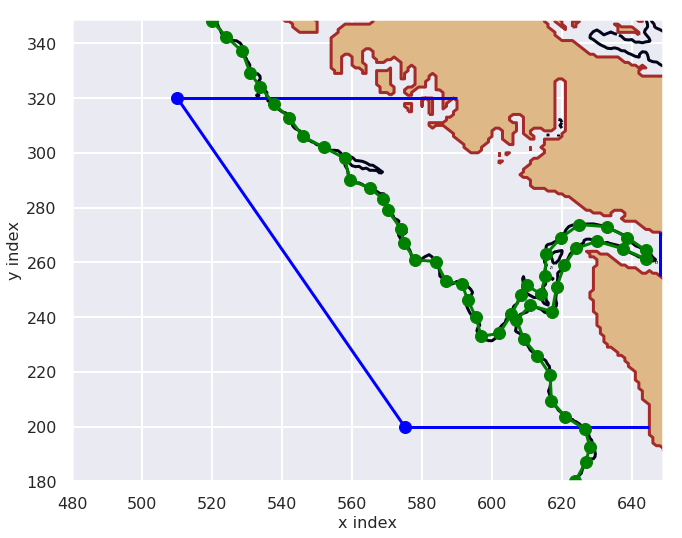

In [90]:



bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]




cmap=plt.cm.get_cmap('nipy_spectral')
#     cmap = plt.cm.get_cmap('gist_rainbow')
cmap.set_bad('#8b7765')
cmin = 0
cmax = 300

import matplotlib as mpl
#     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

fig, ax = plt.subplots(1, 1, figsize=(10,8)); ax.grid()
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
# CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
# CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


# ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

x = [510,575]
y = [320,200]
ax.plot(x, y , 'bo-')

xmin = x_wcvi_slice[np.int(np.min(np.unique(x1)))]-1
xmax = x_wcvi_slice[np.int(np.max(np.unique(x1)))]-1


ymin = y_wcvi_slice[np.int(np.min(np.unique(y1)))]-1
ymax  = y_wcvi_slice[np.int(np.max(np.unique(y1)))]-1


# x_1 = [xmin, xmax]
# y_1 = [ymin, ymin]
# ax.plot(x_1, y_1 , 'go-')

# x_2 = [xmin, xmax]
# y_2 = [ymax, ymax]
# ax.plot(x_2, y_2 , 'go-')

# x_3 = [xmin, xmin]
# y_3 = [ymin, ymax]
# ax.plot(x_3, y_3 , 'go-')

# x_4 = [xmax, xmax]
# y_4 = [ymin, ymax]
# ax.plot(x_4, y_4 , 'go-')

ax.vlines(x = 648, ymin = 255, ymax = 271, color = 'blue')

# ax.get_legend().remove()
# lon_LB08 = -125.4775
# lat_LB08 = 48.4217

# j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
#                                           lon,lat,grid='NEMO',tols=\
#                                           {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
#                                            'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

# ax.scatter(i,j, marker = 'o', c = 'red', s = 300, linewidths=100, label = 'Eddy region')

ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
ax.hlines(y = 320, xmin = 510, xmax=590, color = 'b')
ax.grid()

contour = CS.collections[0]
vs = contour.get_paths()[0].vertices


vert = CS.collections[0].get_paths()[0].vertices

x_200_wcvi = vert[:,0]
y_200_wcvi = vert[:,1]

# for i in range(0, len(x_200_wcvi), 10):
#     plt.plot(x_200_wcvi[i:i+1], y_200_wcvi[i:i+1], 'mo-')
    

Line = ax.plot(x_200_wcvi[::10], y_200_wcvi[::10], 'go-')
fig.tight_layout()





In [91]:
IK = find_index(500)

PK = find_index(1000)

LK = find_index(1500)

JK = find_index(2000)

LI = find_index(2500)

LP = find_index(3000)

MN = find_index(3500)

total_indi_low = np.concatenate((IK,PK,LK,JK,LI, LP, MN))

In [92]:
np.unique(total_indi_low).shape

(1114,)

In [93]:
cross_index_low = []


for i in np.unique(total_indi_low):

    if ((np.max(-traj_depth[:,i]) >= 200) & (np.min(-traj_depth[:,i]) < 200)) == True:
        
        cross_index_low = np.append(arr=cross_index_low, values=i)
        


In [94]:
percentage = cross_index_low.shape[0]/final_age_days.shape[0]

print(percentage)

0.5643044619422573


In [95]:
time_index_low = np.empty_like(cross_index_low)

for k in np.arange(cross_index_low.shape[0]):
    time_index_low[k] = np.min(np.argwhere(-traj_depth[:,cross_index_low[k].astype(int)] > 200))
    
    

In [13]:
cross_index_low = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/cross_index_accurate_iso_low_two_more_months.npy')

cross_index_high = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
cross_index_accurate_iso_high_two_more_months.npy')

In [14]:
traj_days_final_upwell_pool  = final_age_days[cross_index_low.astype(int)]/24

In [15]:
def calculate_kde_days(source):

    if source == 'pool':
        

        
        kde_pool_upwell_all = scipy.stats.gaussian_kde(traj_days_final_upwell_pool)
        kde_pool_timing     = scipy.stats.gaussian_kde(k_time_pool/24) 
        grid = np.linspace(0,200, 10000)   
        
        kde_pool_upwell_all = kde_pool_upwell_all(grid)
        kde_pool_timing     = kde_pool_timing(grid)

        
        return kde_pool_upwell_all, kde_pool_timing,  grid
    
    if source == 'outer':
        

        
        kde_outer_upwell_all = scipy.stats.gaussian_kde(traj_days_final_upwell_outer)
        kde_outer_timing     = scipy.stats.gaussian_kde(k_time_south/24) 
        grid = np.linspace(0,200, 10000)   
        
        kde_outer_upwell_all = kde_outer_upwell_all(grid)
        kde_outer_timing     = kde_outer_timing(grid)
        
        return kde_outer_upwell_all, kde_outer_timing,  grid
        
        

In [16]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



nc_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
accurate_isopycnals_south_outer_shelf__water_particles_two_months_more.nc')
nc_tools.show_variables(nc_file)

odict_keys(['init_x', 'init_y', 'init_z', 'init_t', 'init_age', 'init_transp', 'final_x', 'final_y', 'final_z', 'final_t', 'final_age', 'final_transp', 'traj_lon', 'traj_lat', 'traj_depth', 'traj_time', 'traj_temp', 'traj_salt', 'traj_dens'])


In [17]:


init_x = nc_file.variables['init_x']
init_z = nc_file.variables['init_z']
init_age = nc_file.variables['init_age']

traj_depth = nc_file.variables['traj_depth'][:]
traj_lon   = nc_file.variables['traj_lon'][:]
traj_lat   = nc_file.variables['traj_lat'][:]
traj_rho   = nc_file.variables['traj_dens'][:]
traj_tem   = nc_file.variables['traj_temp'][:]
traj_sal   = nc_file.variables['traj_salt'][:]
traj_time  = nc_file.variables['traj_time']


final_age = nc_file.variables['final_age']


# lon1=nc_file.variables['traj_lon'][:]
# lat1=nc_file.variables['traj_lat'][:]
# dep1=nc_file.variables['traj_depth'][:]
x1=nc_file.variables['init_x'][:]
y1=nc_file.variables['init_y'][:]
t1=nc_file.variables['traj_time'][:]

x_low = x1
y_low = y1

x2=nc_file.variables['final_x'][:]
y2=nc_file.variables['final_y'][:]


final_z = nc_file.variables['final_z'][:]

final_age_days = final_age[:]/(3600)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [18]:
traj_days_final_upwell_outer = final_age_days[cross_index_high.astype(int)]/24

In [19]:
traj_time_days_outer = ((traj_time[:]/np.nanmax(traj_time))*np.max(final_age))/(24*3600)

dep_change_time_outer = traj_time_days_outer[time_index_high.astype(int), cross_index_high.astype(int)]

In [21]:
grid.shape

NameError: name 'grid' is not defined

In [ ]:
print(kde_pool_timing)

In [20]:
k_time_pool = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/time_of_crossing_iso_pool_water_two_more_months.npy')

k_time_south = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/time_of_crossing_iso_south_outer_water_two_more_months.npy')

In [21]:
sns.set_context('paper')

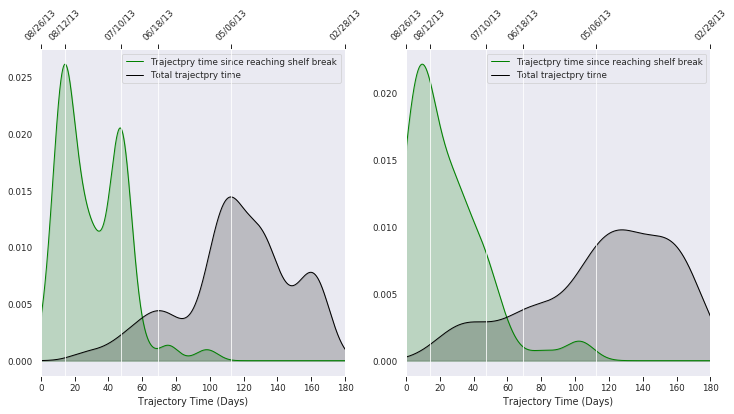

In [22]:
fig = plt.figure(figsize=(12,6))

# fig = plt.figure(figsize=(13,8))

gs2 = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(gs2[0, 0])
ax2 = plt.subplot(gs2[0, 1])

kde_pool_upwell_all, kde_pool_timing,  grid = calculate_kde_days(source='pool')


ax1.plot(grid, kde_pool_timing, lw=1, color = 'g', label = "Trajectpry time since reaching shelf break")
ax1.fill_between(grid, kde_pool_timing, lw=1, color  = 'g', alpha= 0.2)

ax1.plot(grid, kde_pool_upwell_all, lw=1, color = 'k', label = "Total trajectpry time")
ax1.fill_between(grid, kde_pool_upwell_all, color = 'k',alpha = 0.2)




ax1.set_xlim(0,180)
ax1.set_xlabel('Trajectory Time (Days)')
ax1.set_ylabel('')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax1.grid()


ax21 = ax1.twiny()
# date1 = '2013-02-27'
date2 = '2013-08-26'
mydates = pd.date_range(end = date2, periods=180, freq= 'D').strftime('%D')
mydates1 = mydates[::-1]
# new_tick_locations = np.array([0, 59, 119, 179])
new_tick_locations = np.array([0, 14, 47, 69, 112, 179])
# new_tick_locations = np.array([0, 30, 60, 90, 120, 150, 180])
# ax21.set_xlim(ax6.get_xlim())
ax21.set_xticks(new_tick_locations)
ax21.set_xticklabels(mydates1[new_tick_locations], rotation=45)
# ax21.vlines(x=mydates1[69])
# x_fmt = mpl.dates.AutoDateFormatter(mydates1[new_tick_locations])
# ax21.xaxis.set_major_formatter(x_fmt)



ax1.legend(loc = 'best')
# ax2_marg.legend(loc = 'best')


# ax3_marg.legend(loc = 'best')



kde_outer_upwell_all, kde_outer_timing,  grid = calculate_kde_days(source='outer')


ax2.plot(grid, kde_outer_timing, lw=1, color = 'g', label = "Trajectpry time since reaching shelf break")
ax2.fill_between(grid, kde_outer_timing, lw=1, color  = 'g', alpha= 0.2)

ax2.plot(grid, kde_outer_upwell_all, lw=1, color = 'k', label = "Total trajectpry time")
ax2.fill_between(grid, kde_outer_upwell_all, color = 'k',alpha = 0.2)




ax2.set_xlim(0,180)
ax2.set_xlabel('Trajectory Time (Days)')
ax2.set_ylabel('')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax2.grid()


ax22 = ax2.twiny()
# date1 = '2013-02-27'
date2 = '2013-08-26'
mydates = pd.date_range(end = date2, periods=180, freq= 'D').strftime('%D')
mydates1 = mydates[::-1]
# new_tick_locations = np.array([0, 59, 119, 179])
new_tick_locations = np.array([0, 14, 47, 69, 112, 179])
# new_tick_locations = np.array([0, 30, 60, 90, 120, 150, 180])
# ax21.set_xlim(ax6.get_xlim())
ax22.set_xticks(new_tick_locations)
ax22.set_xticklabels(mydates1[new_tick_locations], rotation=45)

ax2.legend(loc = 'best')

In [23]:
cross_index_low = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/cross_index_accurate_iso_low_two_more_months.npy')

time_index_low = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/time_index_accurate_iso_low_two_more_months.npy')

cross_index_high = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/cross_index_accurate_iso_high_two_more_months.npy')

time_index_high = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/time_index_accurate_iso_high_two_more_months.npy')

In [24]:
traj_time

<class 'netCDF4._netCDF4.Variable'>
float64 traj_time(nb_output, ntraj)
    title: What is traj_time ?
    longname: Trajectory: time positions
    units: See global attributes
    missing_value: 1e+20
unlimited dimensions: nb_output
current shape = (3921, 363)
filling on, default _FillValue of 9.969209968386869e+36 used

In [25]:
def calculate_kde_days_depth_change(source):

    if source == 'pool':
        

        
        kde_pool_upwell_all = scipy.stats.gaussian_kde(traj_days_final_upwell_pool)
        kde_pool_timing     = scipy.stats.gaussian_kde(dep_change_time_pool) 
        grid = np.linspace(0,200, 10000)   
        
        kde_pool_upwell_all = kde_pool_upwell_all(grid)
        kde_pool_timing     = kde_pool_timing(grid)

        
        return kde_pool_upwell_all, kde_pool_timing,  grid
    
    if source == 'outer':
        

        
        kde_outer_upwell_all = scipy.stats.gaussian_kde(traj_days_final_upwell_outer)
        kde_outer_timing     = scipy.stats.gaussian_kde(dep_change_time_outer) 
        grid = np.linspace(0,200, 10000)   
        
        kde_outer_upwell_all = kde_outer_upwell_all(grid)
        kde_outer_timing     = kde_outer_timing(grid)
        
        return kde_outer_upwell_all, kde_outer_timing,  grid
        
        

In [26]:
sns.set_context('paper')

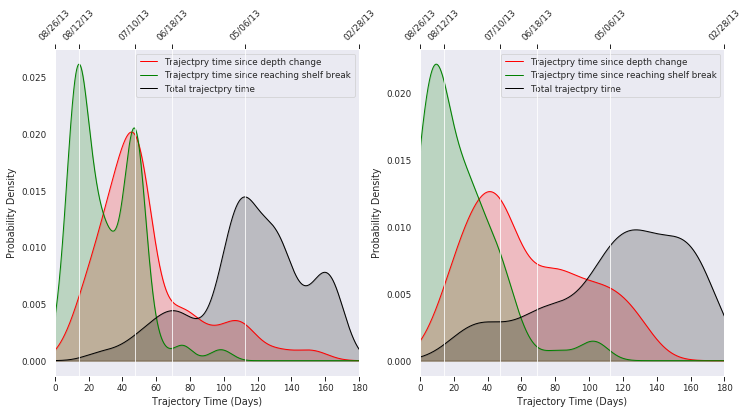

In [78]:
fig = plt.figure(figsize=(12,6))

# fig = plt.figure(figsize=(13,8))

gs2 = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(gs2[0, 0])
ax2 = plt.subplot(gs2[0, 1])

kde_pool_upwell_all, kde_pool_timing_depth,  grid = calculate_kde_days_depth_change(source='pool')


ax1.plot(grid, kde_pool_timing_depth, lw=1, color = 'r', label = "Trajectpry time since depth change")
ax1.fill_between(grid, kde_pool_timing_depth, lw=1, color  = 'r', alpha= 0.2)

ax1.plot(grid, kde_pool_timing, lw=1, color = 'g', label = "Trajectpry time since reaching shelf break")
ax1.fill_between(grid, kde_pool_timing, lw=1, color  = 'g', alpha= 0.2)

ax1.plot(grid, kde_pool_upwell_all, lw=1, color = 'k', label = "Total trajectpry time")
ax1.fill_between(grid, kde_pool_upwell_all, color = 'k',alpha = 0.2)




ax1.set_xlim(0,180)
ax1.set_xlabel('Trajectory Time (Days)')
ax1.set_ylabel('')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax1.grid()


ax21 = ax1.twiny()
# date1 = '2013-02-27'
date2 = '2013-08-26'
mydates = pd.date_range(end = date2, periods=180, freq= 'D').strftime('%D')
mydates1 = mydates[::-1]
# new_tick_locations = np.array([0, 59, 119, 179])
new_tick_locations = np.array([0, 14, 47, 69, 112, 179])
# new_tick_locations = np.array([0, 30, 60, 90, 120, 150, 180])
# ax21.set_xlim(ax6.get_xlim())
ax21.set_xticks(new_tick_locations)
ax21.set_xticklabels(mydates1[new_tick_locations], rotation=45)
# ax21.vlines(x=mydates1[69])
# x_fmt = mpl.dates.AutoDateFormatter(mydates1[new_tick_locations])
# ax21.xaxis.set_major_formatter(x_fmt)



ax1.legend(loc = 'best')

ax1.set_ylabel('Probability Density')
# ax2_marg.legend(loc = 'best')


# ax3_marg.legend(loc = 'best')



kde_outer_upwell_all, kde_outer_timing_depth,  grid = calculate_kde_days_depth_change(source='outer')


ax2.plot(grid, kde_outer_timing_depth, lw=1, color = 'r', label = "Trajectpry time since depth change")
ax2.fill_between(grid, kde_outer_timing_depth, lw=1, color  = 'r', alpha= 0.2)

ax2.plot(grid, kde_outer_timing, lw=1, color = 'g', label = "Trajectpry time since reaching shelf break")
ax2.fill_between(grid, kde_outer_timing, lw=1, color  = 'g', alpha= 0.2)

ax2.plot(grid, kde_outer_upwell_all, lw=1, color = 'k', label = "Total trajectpry time")
ax2.fill_between(grid, kde_outer_upwell_all, color = 'k',alpha = 0.2)




ax2.set_xlim(0,180)
ax2.set_xlabel('Trajectory Time (Days)')
ax2.set_ylabel('')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax2.grid()


ax22 = ax2.twiny()
# date1 = '2013-02-27'
date2 = '2013-08-26'
mydates = pd.date_range(end = date2, periods=180, freq= 'D').strftime('%D')
mydates1 = mydates[::-1]
# new_tick_locations = np.array([0, 59, 119, 179])
new_tick_locations = np.array([0, 14, 47, 69, 112, 179])
# new_tick_locations = np.array([0, 30, 60, 90, 120, 150, 180])
# ax21.set_xlim(ax6.get_xlim())
ax22.set_xticks(new_tick_locations)
ax22.set_xticklabels(mydates1[new_tick_locations], rotation=45)

ax2.legend(loc = 'best')

ax2.set_ylabel('Probability Density')

In [28]:
def find_principal_axis_of_dataset_in_degrees(u_data,v_data):
    
    u_perturb = u_data - np.mean(u_data)
    v_perturb = v_data - np.mean(v_data)
    
    coords = np.vstack([u_perturb, v_perturb])

    cov = np.cov(coords)
    
    evals, evecs = np.linalg.eig(cov)

    sort_indices = np.argsort(evals)[::-1]
    
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]
    
    theta = np.tanh((x_v1)/(y_v1))  
#     rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
#                       [np.sin(theta), np.cos(theta)]])
#     transformed_mat = rotation_mat * coords
#     # plot the transformed blob
#     x_transformed, y_transformed = transformed_mat.A

    return np.rad2deg(theta)

def find_major_eigenvectors(u_data,v_data):
    
    u_data = u_data[~np.isnan(u_data)]
    v_data = v_data[~np.isnan(v_data)]
    
    u_perturb = u_data - np.mean(u_data)
    v_perturb = v_data - np.mean(v_data)
    
    coords = np.vstack([u_perturb, v_perturb])

    cov = np.cov(coords)
    
    evals, evecs = np.linalg.eig(cov)

    sort_indices = np.argsort(evals)[::-1]
    
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]
    
    return x_v1, y_v1, x_v2, y_v2


    
def U_timeseries_at_WCVI_locations(grid_U):
    
    u_vel = grid_U.variables['uo'][:,:,:,:]

    
    vector_u = namedtuple('vector_u', 'u_vel')

    return vector_u(u_vel)


def V_timeseries_at_WCVI_locations(grid_V):
    
    v_vel = grid_V.variables['vo'][:,:,:,:]

    
    vector_v = namedtuple('vector_v', 'v_vel')

    return vector_v(v_vel)




def uv_wind_timeseries_at_point(grid_weather, j, i, datetimes=False):
    """Return the u and v wind components and time counter values
    at a single grid point from a weather forcing dataset.

    :arg grid_weather: Weather forcing dataset, typically from an
                       :file:`ops_yYYYYmMMdDD.nc` file produced by the
                       :py:mod:`nowcast.workers.grid_to_netcdf` worker.
    :type grid_weather: :py:class:`netCDF4.Dataset`

    :arg int j: j-direction (longitude) index of grid point to get wind
                components at.

    :arg int i: i-direction (latitude) index of grid point to get wind
                components at.

    :arg boolean datetimes: Return time counter values as
                            :py:class:`datetime.datetime` objects if
                            :py:obj:`True`, otherwise return them as
                            :py:class:`arrow.Arrow` objects (the default).

    :returns: 2-tuple of 1-dimensional :py:class:`numpy.ndarray` objects,
              The :py:attr:`u` attribute holds the u-direction wind
              component,
              The :py:attr:`v` attribute holds the v-direction wind
              component,
              and the :py:attr:`time` attribute holds the time counter
              values.
    :rtype: :py:class:`collections.namedtuple`
    """
    u_wind = grid_weather.variables['u_wind'][:, j, i]
    v_wind = grid_weather.variables['v_wind'][:, j, i]
    time = timestamp(grid_weather, range(len(u_wind)))
    if datetimes:
        time = np.array([a.datetime for a in time])
    wind_ts = namedtuple('wind_ts', 'u, v, time')

    return wind_ts(u_wind, v_wind, np.array(time))

def timestamp(dataset, tindex, time_var='time_counter'):
    """Return the time stamp of the tindex time_counter value(s) in dataset.

    The time stamp is calculated by adding the time_counter[tindex] value
    (in seconds) to the dataset's time_counter.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset`

    :arg tindex: time_counter variable index.
    :type tindex: int or iterable

    :arg time_var: name of the time variable
    :type time_var: str

    :returns: Time stamp value(s) at tindex in the dataset.
    :rtype: :py:class:`Arrow` instance or list of instances
    """
    time_orig = time_origin(dataset, time_var=time_var)
    time_counter = dataset.variables[time_var]
    try:
        iter(tindex)
    except TypeError:
        tindex = [tindex]
    results = []
    for i in tindex:
        try:
            results.append(time_orig + timedelta(seconds=time_counter[i]))
        except IndexError:
            raise IndexError(
                'time_counter variable has no tindex={}'.format(tindex))
    if len(results) > 1:
        return results
    else:

        return results[0]

def time_origin(dataset, time_var='time_counter'):
    """Return the time_var.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset` or :py:class:`xarray.Dataset`

    :arg time_var: name of time variable
    :type time_var: str

    :returns: Value of the time_origin attribute of the time_counter
              variable.
    :rtype: :py:class:`Arrow` instance
    """
    try:
        time_counter = dataset.variables[time_var]
    except KeyError:
        raise KeyError(
            'dataset does not have {time_var} variable'.format(
                time_var=time_var))
    try:
        # netCDF4 dataset
        time_orig = time_counter.time_origin.title()
    except AttributeError:
        try:
            # xarray dataset
            time_orig = time_counter.attrs['time_origin'].title()
        except KeyError:
            raise AttributeError(
                'NetCDF: '
                '{time_var} variable does not have '
                'time_origin attribute'.format(time_var=time_var))
    value = arrow.get(
        time_orig,
        ['YYYY-MMM-DD HH:mm:ss',
         'DD-MMM-YYYY HH:mm:ss',
         'YYYY-MM-DD HH:mm:ss'])

    return value

import numpy

def smooth(x,window_len=24,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s, mode='same')
    
    return y[window_len - 1:-window_len + 1]

    
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in np.arange(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df









"""
Constants
=========
"""

# ---- physical constants
g = 9.8  # 9.7803 in COARE FIXME: change to sw.grav
""" acceleration due to gravity [m s :sup:`-2`] """

sigmaSB = 5.6697e-8
""" Stefan-Boltzmann constant [W m :sup:`-2` K :sup:`-4`] """

eps_air = 0.62197
""" Molecular weight ratio [water air :sup:`-1`] """

CtoK = 273.15  # 273.16
""" Conversion factor for [:math:`^\\circ` C] to [:math:`^\\circ` K] """

gas_const_R = 287.04  # NOTE: 287.1 in COARE
""" Gas constant for dry air [J kg :sup:`-1` K :sup:`-1`] """


# ---- meteorological constants
kappa = 0.4  # NOTE: 0.41
""" von Karman's constant """

charn = Charnock_alpha = 0.011  # NOTE: 0.018
""" Charnock constant. For determining roughness length at sea given friction
velocity, used in Smith formulas for drag coefficient and also in Fairall and
Edson. Ese alpha = 0.011 for open-ocean and alpha = 0.018 for fetch-limited
(coastal) regions."""

R_roughness = 0.11
""" limiting roughness Reynolds for aerodynamically smooth flow """


# ---- defaults suitable for boundary-layer studies
cp = 1004.7
""" heat capacity of air [J kg :sup:`-1` K :sup:`-1`] """

Qsat_coeff = 0.98
""" saturation specific humidity coefficient reduced by 2% over salt water """


# ------ short-wave flux calculations
Solar_const = 1368.0
""" The solar constant [W/m^2] represents a mean of satellite measurements
made over the last sunspot cycle (1979-1995) taken from Coffey et al (1995),
Earth System Monitor, 6, 6-10."""


# ---- long-wave flux calculations
emiss_lw = 0.985
""" long-wave emissivity of ocean from Dickey et al (1994), J. Atmos. Oceanic
Tech., 11, 1057-1076."""

# Default values
P_default = 1020.





def stress(sp, z=5., drag='largepond', rho_air=1.22, Ta=10.):
    """Computes the neutral wind stress.
    Parameters
    ----------
    sp : array_like
         wind speed [m s :sup:`-1`]
    z : float, array_like, optional
        measurement height [m]
    rho_air : array_like, optional
           air density [kg m :sup:`-3`]
    drag : str
           neutral drag by:
           'largepond' <-- default
           'smith'
           'vera'
    Ta : array_like, optional
         air temperature [:math:`^\\circ` C]
    Returns
    -------
    tau : array_like
          wind stress  [N m :sup:`-2`]
    See Also
    --------
    cdn
    Examples
    --------
    >>> from airsea import windstress as ws
    >>> ws.stress([10., 0.2, 12., 20., 30., 50.], 10)
    array([  1.40300000e-01,   5.61200000e-05,   2.23113600e-01,
             8.73520000e-01,   2.67912000e+00,   1.14070000e+01])
    >>> kw = dict(rho_air=1.02, Ta=23.)
    >>> ws.stress([10., 0.2, 12., 20., 30., 50.], 15, 'smith', **kw)
    array([  1.21440074e-01,   5.32531576e-05,   1.88322389e-01,
             6.62091968e-01,   1.85325310e+00,   7.15282267e+00])
    >>> ws.stress([10., 0.2, 12., 20., 30., 50.], 8, 'vera')
    array([  1.50603698e-01,   7.16568379e-04,   2.37758830e-01,
             9.42518454e-01,   3.01119044e+00,   1.36422742e+01])
    References
    ----------
    .. [1] Large and Pond (1981), J. Phys. Oceanog., 11, 324-336.
    .. [2] Smith (1988), J. Geophys. Res., 93, 311-326.
    .. [3] E. Vera (1983) FIXME eqn. 8 in Large, Morzel, and Crawford (1995),
    J. Phys. Oceanog., 25, 2959-2971.
    Modifications: Original from AIR_SEA TOOLBOX, Version 2.0
    03-08-1997: version 1.0
    08-26-1998: version 1.1 (revised by RP)
    04-02-1999: versin 1.2 (air density option added by AA)
    08-05-1999: version 2.0
    11-26-2010: Filipe Fernandes, Python translation.
    """
    z, sp = np.asarray(z), np.asarray(sp)
    Ta, rho_air = np.asarray(Ta), np.asarray(rho_air)

    # Find cd and ustar.
    if drag == 'largepond':
        cd, sp = cdn(sp, z, 'largepond')
    elif drag == 'smith':
        cd, sp = cdn(sp, z, 'smith', Ta)
    elif drag == 'vera':
        cd, sp = cdn(sp, z, 'vera')
    else:
        print('Unknown method')  # FIXME: raise a proper python error

    tau = rho_air * (cd * sp ** 2)

    return tau


def cdn(sp, z, drag='largepond', Ta=10):
    """Computes neutral drag coefficient.
    Methods available are: Large & Pond (1981),  Vera (1983) or Smith (1988)
    Parameters
    ----------
    sp : array_like
         wind speed [m s :sup:`-1`]
    z : float, array_like
        measurement height [m]
    drag : str
           neutral drag by:
           'largepond' <-- default
           'smith'
           'vera'
    Ta : array_like, optional for drag='smith'
         air temperature [:math:`^\\circ` C]
    Returns
    -------
    cd : float, array_like
         neutral drag coefficient at 10 m
    u10 : array_like
          wind speed at 10 m [m s :sup:`-1`]
    See Also
    --------
    stress, spshft, visc_air
    Notes
    -----
    Vera (1983): range of fit to data is 1 to 25 [m s :sup:`-1`].
    Examples
    --------
    >>> from airsea import windstress as ws
    >>> ws.cdn([10., 0.2, 12., 20., 30., 50.], 10)
    (array([ 0.00115,  0.00115,  0.00127,  0.00179,  0.00244,  0.00374]),
     array([ 10. ,   0.2,  12. ,  20. ,  30. ,  50. ]))
    >>> ws.cdn([10., 0.2, 12., 20., 30., 50.], 15, 'vera')
    (array([ 0.00116157,  0.01545237,  0.00126151,  0.00174946,  0.00242021,
            0.00379521]),
     array([  9.66606155,   0.17761896,  11.58297824, 19.18652915,
            28.5750255 ,  47.06117334]))
    >>> ws.cdn([10., 0.2, 12., 20., 30., 50.], 20, 'smith', 20.)
    (array([ 0.00126578,  0.00140818,  0.00136533,  0.00173801,  0.00217435,
            0.00304636]),
     array([  9.41928554,   0.18778865,  11.27787697,  18.65250005,
            27.75712916,  45.6352786 ]))
    References
    ----------
    .. [1] Large and Pond (1981), J. Phys. Oceanog., 11, 324-336.
    .. [2] Smith (1988), J. Geophys. Res., 93, 311-326.
    .. [3] E. Vera (1983) FIXME eqn. 8 in Large, Morzel, and Crawford (1995),
    J. Phys. Oceanog., 25, 2959-2971.
    Modifications: Original from AIR_SEA TOOLBOX, Version 2.0
    03-08-1997: version 1.0
    08-26-1998: version 1.1 (vectorized by RP)
    08-05-1999: version 2.0
    11-26-2010: Filipe Fernandes, Python translation.
    """
    # convert input to numpy array
    sp, z, Ta = np.asarray(sp), np.asarray(z), np.asarray(Ta)

    tol = 0.00001  # Iteration end point.

    if drag == 'largepond':
        a = np.log(z / 10.) / kappa  # Log-layer correction factor.
        u10o = np.zeros(sp.shape)
        cd = 1.15e-3 * np.ones(sp.shape)
        u10 = sp / (1 + a * np.sqrt(cd))
        ii = np.abs(u10 - u10o) > tol

        while np.any(ii):
            u10o = u10
            cd = (4.9e-4 + 6.5e-5 * u10o)  # Compute cd(u10).
            cd[u10o < 10.15385] = 1.15e-3
            u10 = sp / (1 + a * np.sqrt(cd))  # Next iteration.
            # Keep going until iteration converges.
            ii = np.abs(u10 - u10o) > tol

    elif drag == 'smith':
        visc = visc_air(Ta)

        # Remove any sp==0 to prevent division by zero
        # i = np.nonzero(sp == 0)
        # sp[i] = 0.1 * np.ones(len(i)) FIXME

        # initial guess
        ustaro = np.zeros(sp.shape)
        ustarn = 0.036 * sp

        # iterate to find z0 and ustar
        ii = np.abs(ustarn - ustaro) > tol
        while np.any(ii):
            ustaro = ustarn
            z0 = Charnock_alpha * ustaro ** 2 / g + R_roughness * visc / ustaro
            ustarn = sp * (kappa / np.log(z / z0))
            ii = np.abs(ustarn - ustaro) > tol

        sqrcd = kappa / np.log(10. / z0)
        cd = sqrcd ** 2
        u10 = ustarn / sqrcd
    elif drag == 'vera':
        # constants in fit for drag coefficient
        A = 2.717e-3
        B = 0.142e-3
        C = 0.0764e-3

        a = np.log(z / 10.) / kappa  # Log-layer correction factor.
        # Don't start iteration at 0 to prevent blowups.
        u10o = np.zeros(sp.shape) + 0.1
        cd = A / u10o + B + C * u10o
        u10 = sp / (1 + a * np.sqrt(cd))

        ii = np.abs(u10 - u10o) > tol
        while np.any(ii):
            u10o = u10
            cd = A / u10o + B + C * u10o
            u10 = sp / (1 + a * np.sqrt(cd))  # Next iteration.
            # Keep going until iteration converges.
            ii = np.abs(u10 - u10o) > tol
    else:
        print('Unknown method')  # FIXME: raise a proper python error.

    return cd, u10


def get_alongshore_currents(u_curr, v_curr):
    
    pri_angle    = find_principal_axis_of_dataset_in_degrees(u_data=u_curr, v_data=v_curr)
    pri_angle    = np.radians(pri_angle)
#     direc        = 90 - np.rad2deg(np.arctan(v_curr/u_curr))
#     Speed_curr   = np.sqrt(u_curr**2 + v_curr**2)
    
    coords = np.vstack([u_curr, v_curr])
    
    rotation_mat = np.matrix([[np.cos(pri_angle), -np.sin(pri_angle)],
                  [np.sin(pri_angle), np.cos(pri_angle)]])
    transformed_mat = rotation_mat * coords
    
    alongshore_rot = transformed_mat[1,:]
    
    alongshore_rot = alongshore_rot.tolist()
    
    
    
    
    
#     dir_new      = direc - pri_angle
    
#     alongshore_rot = np.empty_like(dir_new)
#     alongshore_rot[:] = np.multiply(Speed_curr[:],np.sin(np.deg2rad(dir_new)))
    
    return alongshore_rot[0]

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]
    
    
def calculate_strength_of_adcp_undercurrent(t, adcp_alongshore, adcp_depths):
       
    ind  = np.array(np.where(adcp_alongshore[:] > 0))
    
    if (ind.size == 0) == False:

        mean_undercurr = np.mean(adcp_alongshore[ind])

        if ind[0][0] !=  ind[0][-1]:

            depths_mean = np.mean(adcp_depths[ind[0][0]:ind[0][-1]])

            strength = np.trapz(adcp_alongshore[ind[0][0]:ind[0][-1]], adcp_depths[ind[0][0]:ind[0][-1]])


        else:
            depths_mean = adcp_depths[ind[0][0]]
            
    else:
        strength = 0

#     strength = np.multiply(mean_undercurr,depths_mean)
        
    return strength



def calculate_strength_of_model_undercurrent(t, model_alongshore, model_depths):

    ind  = np.array(np.where(model_alongshore[20:] > 0))
    
    if (ind.size == 0) == False:
        
        if ind[0][0] !=  ind[0][-1]:

            mean_undercurr = np.mean(model_alongshore[20+ind[0][0]:20+ind[0][-1]])

            depths_mean = np.absolute(np.mean(zlevels[20+ind[0][0]:20+ind[0][-1]]))

            strength = np.trapz(model_alongshore[20+ind[0][0]:20+ind[0][-1]], zlevels[20+ind[0][0]:20+ind[0][-1]])
            
            if np.ma.is_masked(strength) ==  True:
            
                strength = np.multiply(depths_mean, mean_undercurr)

        else:
            depths_mean = np.absolute(zlevels[20+ind[0][0]])
            mean_undercurr = np.absolute(model_alongshore[20+ind[0][0]])
            strength = np.multiply(depths_mean, mean_undercurr)
            
    else:
        strength = 0

#     strength = np.multiply(mean_undercurr,depths_mean)
        
    return strength

print("The functions are defined")


The functions are defined


In [71]:
newport_data = pd.read_table('/data/ssahu/Falkor_2013/winds/Newport_winds_unfiltered.csv', delim_whitespace=1, parse_dates= True, header = None, skiprows=2)


df_cut = newport_data.drop(newport_data.columns[7:], axis=1)
columns = ['Year','Month','Day','Hour','Min','Wind Direction (deg)','Wind Speed','GDR','GST','GTIME']
effective = columns[:7]
df_cut.columns = effective


df_cut['Year']   = df_cut['Year'].astype(str)
df_cut['Day']    = df_cut['Day'].astype(str)
df_cut['Month']  = df_cut['Month'].astype(str)
df_cut['Hour']   = df_cut["Hour"].astype(str)

df_cut.columns = df_cut.columns.str.replace(' ', '')



df_cut['Datetime'] = df_cut['Year'] + "-" + df_cut['Month'] + "-" + df_cut['Day']+ " " + df_cut["Hour"] + ":00:00"

df_cut["Datetime"] = pd.to_datetime(df_cut["Datetime"])


df_cut = df_cut.iloc[:,4:]

df_cut = df_cut.set_index(pd.DatetimeIndex(df_cut["Datetime"]))

df_subset = df_cut.loc['2013-02-28 01:00:00':'2013-08-31 23:00:00']

df_subset = df_subset.resample('60T').mean().reset_index()


newport_datetime = df_subset['Datetime']

ws_newport = df_subset['WindSpeed']
wd_newport = df_subset['WindDirection(deg)']


u_wind_newport = np.multiply(ws_newport[:],np.cos(wd_newport))

v_wind_newport = np.multiply(ws_newport[:],np.sin(wd_newport))

df_subset_daily = df_cut.loc['2013-02-28 01:00:00':'2013-08-31 23:00:00']

df_subset_daily = df_subset_daily.resample('D').mean().reset_index()

ws_newport_daily = df_subset_daily['WindSpeed']
wd_newport_daily = df_subset_daily['WindDirection(deg)']


u_wind_newport_daily = np.multiply(ws_newport_daily[:],np.cos(wd_newport_daily))

v_wind_newport_daily = np.multiply(ws_newport_daily[:],np.sin(wd_newport_daily))

La_Peruse_data = pd.read_table('/data/ssahu/Falkor_2013/winds/La_persue_wave_buoy.csv',delim_whitespace=1,header = None, skiprows=7)

a = La_Peruse_data[0].str.split(',', expand=True)

b = La_Peruse_data[1].str.split(',', expand=True)

df_La_Peruse = pd.concat([a, b], axis=1)

df_cut = df_La_Peruse.drop(df_La_Peruse.columns[14:], axis=1)

columns = ['STN_ID','DATE','TIME','Qflag','LATITUDE','LONGITUDE','DEPTH','VCAR','VTPK','VWH','VCMX','VTP','WDIR','WSPD','WSS','GSPD','WDIR','WSPD','WSS','GSPD','ATMS','ATMS','DRYT','SSTP']

effective = columns[:14]

df_cut.columns = effective
df_cut = df_cut.drop('Qflag',axis =1)

df_cut['Date_time']= df_cut['DATE'] + " " + df_cut['TIME']

LA_PERUSE_array = df_cut.as_matrix()

start_index_2013_Feb  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '02/28/2013')))[0,0]

end_index_2013_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '08/31/2013')))[-1,0]

wind_spd = LA_PERUSE_array[start_index_2013_Feb:end_index_2013_September,-2].astype(np.float)

wind_dir = LA_PERUSE_array[start_index_2013_Feb:end_index_2013_September,-3].astype(np.float)

u_wind = np.multiply(wind_spd[:],np.cos(wind_dir))

v_wind = np.multiply(wind_spd[:],np.sin(wind_dir))

time_2013 = LA_PERUSE_array[start_index_2013_Feb:end_index_2013_September,-1].astype(str)

datetime_2013 = np.empty_like(time_2013)

for i in np.arange(datetime_2013.shape[0]):
    datetime_2013[i] = datetime.strptime(time_2013[i], '%m/%d/%Y %H:%M')
    
datetime_2013 = datetime_2013.astype(np.datetime64)

ws_newport = df_subset['WindSpeed']
wd_newport = df_subset['WindDirection(deg)']

ws_La_Perouse = wind_spd
wd_La_Perouse = wind_dir

theta = find_principal_axis_of_dataset_in_degrees(u_data=u_wind, v_data=v_wind)

x_v1, y_v1, x_v2, y_v2 = find_major_eigenvectors(u_data=u_wind, v_data=v_wind)


x_v1_new, y_v1_new, x_v2_new, y_v2_new = find_major_eigenvectors(u_data=u_wind_newport, v_data=v_wind_newport)

ws_newport = df_subset['WindSpeed']
wd_newport = df_subset['WindDirection(deg)']

ws_La_Perouse = wind_spd
wd_La_Perouse = wind_dir

theta = find_principal_axis_of_dataset_in_degrees(u_data=u_wind, v_data=v_wind)


wind_spd = LA_PERUSE_array[start_index_2013_Feb:end_index_2013_September,-2].astype(np.float)

wind_dir = LA_PERUSE_array[start_index_2013_Feb:end_index_2013_September,-3].astype(np.float)

v_wind_rot = np.empty_like(wind_dir)

v_wind_rot[:] = -1*np.multiply(wind_spd[:],np.cos(np.deg2rad(wind_dir[:] - theta)))

# v_wind_rot = np.multiply(wind_spd[:],np.sin(np.deg2rad(wind_dir[:] - 57)))

time_2013 = LA_PERUSE_array[start_index_2013_Feb:end_index_2013_September,-1].astype(str)

datetime_2013 = np.empty_like(time_2013)

for i in np.arange(datetime_2013.shape[0]):
    datetime_2013[i] = datetime.strptime(time_2013[i], '%m/%d/%Y %H:%M')
    
datetime_2013 = datetime_2013.astype(np.datetime64)

range = pd.date_range('2013-02-28', '2013-08-31', freq='D')



La_perouse_series = pd.Series(v_wind_rot, index=datetime_2013)
daily_north_La_Perouse = La_perouse_series.resample('D').mean()

La_perouse_stress_daily = np.sign(daily_north_La_Perouse)*stress(sp=daily_north_La_Perouse)

range = pd.date_range('2013-02-28', '2013-08-31', freq='D')



Newport_series_daily = pd.Series(v_wind_newport_daily)
Newport_stress_daily = np.sign(-Newport_series_daily)*stress(sp=Newport_series_daily)

date1_Newport = '2013-02-28'
date2_Newport = '2013-08-31'
mydates_Newport = pd.date_range(date1_Newport, date2_Newport, freq= 'D')

colors = cm.copper(np.linspace(0, 1, 50))
colors_speed = cm.ocean(np.linspace(0, 1, 50))

mat_file = '/data/ssahu/Falkor_2013/winds/wind_Newport_2013_v6.mat'

mat = scipy.io.loadmat(mat_file)

wind_stress_newport = mat['tau'][:,0]



date1_Newport = '2013-02-28'
date2_Newport = '2013-08-31'
mydates_Newport_1 = pd.date_range(date1_Newport, date2_Newport, freq= 'D')

date1 = '2013-04-29'
date2 = '2013-10-25'
mydates = pd.date_range(date1, date2, freq= 'D')

A1_data = pd.read_table('/data/ssahu/IOS_data/ADCP_E1_A1/a1_20130507_20140512_0456m.csv',delim_whitespace=1,header = None, skiprows=438)

str_stuff = np.array(['Record_Number', 'Date', 'Time', 'Pitch', 'Roll', 'Heading', 'Pressure', 'Temperature'], dtype = 'str')

bin_depths = np.array([80.13,
         96.13,
        112.13,
        128.13,
        144.13,
        160.13,
        176.13,
        192.13,
        208.13,
        224.13,
        240.13,
        256.13,
        272.13,
        288.13,
        304.13,
        320.13,
        336.13,
        352.13,
        368.13,
        384.13,
        400.13,
        416.13,
        432.13], dtype = 'str')

variables = np.array(['vel_north', 'vel_east', 'vel_vert', 'back_scatter_mean'], dtype = 'str')

column_data = []

for j in bin_depths:
    for i in variables:
        column_data = np.append(arr=column_data, values=i+'_'+j)
    

columns_A1 = np.concatenate((str_stuff, column_data), axis = 0)

A1_data.columns = columns_A1

vel_north_80 = np.array(A1_data['vel_north_80.13'], dtype = np.float)[0:5608]
vel_east_80  = np.array(A1_data['vel_east_80.13'], dtype = np.float)[0:5608]
mag_80       = np.sqrt(vel_east_80**2+vel_north_80**2)
mag_80[mag_80 > 2] = 'Nan'

vel_north_96= np.array(A1_data['vel_north_96.13'], dtype = np.float)[0:5608]
vel_east_96 = np.array(A1_data['vel_east_96.13'], dtype = np.float)[0:5608]
mag_96       = np.sqrt(vel_east_96**2+vel_north_96**2)
mag_96[mag_96 > 2] = 'Nan'

vel_north_112 = np.array(A1_data['vel_north_112.13'], dtype = np.float)[0:5608]
vel_east_112  = np.array(A1_data['vel_east_112.13'], dtype = np.float)[0:5608]
mag_112       = np.sqrt(vel_east_112**2+vel_north_112**2)
mag_112[mag_112 > 2] = 'Nan'

vel_north_128 = np.array(A1_data['vel_north_128.13'], dtype = np.float)[0:5608]
vel_east_128  = np.array(A1_data['vel_east_128.13'], dtype = np.float)[0:5608]
mag_128       = np.sqrt(vel_east_128**2+vel_north_128**2)
mag_128[mag_128 > 2] = 'Nan'

vel_north_144 = np.array(A1_data['vel_north_144.13'], dtype = np.float)[0:5608]
vel_east_144  = np.array(A1_data['vel_east_144.13'], dtype = np.float)[0:5608]
mag_144       = np.sqrt(vel_east_144**2+vel_north_144**2)

vel_north_160= np.array(A1_data['vel_north_160.13'], dtype = np.float)[0:5608]
vel_east_160 = np.array(A1_data['vel_east_160.13'], dtype = np.float)[0:5608]
mag_160       = np.sqrt(vel_east_160**2+vel_north_160**2)
mag_160[mag_160 > 2] = 'Nan'

vel_north_176= np.array(A1_data['vel_north_176.13'], dtype = np.float)[0:5608]
vel_east_176 = np.array(A1_data['vel_east_176.13'], dtype = np.float)[0:5608]
mag_176       = np.sqrt(vel_east_176**2+vel_north_176**2)
mag_176[mag_176 > 2] = 'Nan'

vel_north_192 = np.array(A1_data['vel_north_192.13'], dtype = np.float)[0:5608]
vel_east_192  = np.array(A1_data['vel_east_192.13'], dtype = np.float)[0:5608]
mag_192      = np.sqrt(vel_east_192**2+vel_north_192**2)

vel_north_208 = np.array(A1_data['vel_north_208.13'], dtype = np.float)[0:5608]
vel_east_208  = np.array(A1_data['vel_east_208.13'], dtype = np.float)[0:5608]
mag_208      = np.sqrt(vel_east_208**2+vel_north_208**2)

vel_north_224 = np.array(A1_data['vel_north_224.13'], dtype = np.float)[0:5608]
vel_east_224 = np.array(A1_data['vel_east_224.13'], dtype = np.float)[0:5608]
mag_224      = np.sqrt(vel_east_224**2+vel_north_224**2)

vel_north_240 = np.array(A1_data['vel_north_240.13'], dtype = np.float)[0:5608]
vel_east_240 = np.array(A1_data['vel_east_240.13'], dtype = np.float)[0:5608]
mag_240      = np.sqrt(vel_east_240**2+vel_north_240**2)

vel_north_256 = np.array(A1_data['vel_north_256.13'], dtype = np.float)[0:5608]
vel_east_256 = np.array(A1_data['vel_east_256.13'], dtype = np.float)[0:5608]
mag_256      = np.sqrt(vel_east_256**2+vel_north_256**2)

vel_north_272 = np.array(A1_data['vel_north_272.13'], dtype = np.float)[0:5608]
vel_east_272 = np.array(A1_data['vel_east_272.13'], dtype = np.float)[0:5608]
mag_272      = np.sqrt(vel_east_272**2+vel_north_272**2)

vel_north_288 = np.array(A1_data['vel_north_288.13'], dtype = np.float)[0:5608]
vel_east_288 = np.array(A1_data['vel_east_288.13'], dtype = np.float)[0:5608]
mag_288      = np.sqrt(vel_east_288**2+vel_north_288**2)

vel_north_304 = np.array(A1_data['vel_north_304.13'], dtype = np.float)[0:5608]
vel_east_304 = np.array(A1_data['vel_east_304.13'], dtype = np.float)[0:5608]
mag_304      = np.sqrt(vel_east_304**2+vel_north_304**2)

vel_north_320 = np.array(A1_data['vel_north_320.13'], dtype = np.float)[0:5608]
vel_east_320 = np.array(A1_data['vel_east_320.13'], dtype = np.float)[0:5608]
mag_320      = np.sqrt(vel_east_320**2+vel_north_320**2)

vel_north_336 = np.array(A1_data['vel_north_336.13'], dtype = np.float)[0:5608]
vel_east_336 = np.array(A1_data['vel_east_336.13'], dtype = np.float)[0:5608]
mag_336      = np.sqrt(vel_east_336**2+vel_north_336**2)

vel_north_352 = np.array(A1_data['vel_north_352.13'], dtype = np.float)[0:5608]
vel_east_352 = np.array(A1_data['vel_east_352.13'], dtype = np.float)[0:5608]
mag_352      = np.sqrt(vel_east_352**2+vel_north_352**2)


vel_north_368 = np.array(A1_data['vel_north_368.13'], dtype = np.float)[0:5608]
vel_east_368 = np.array(A1_data['vel_east_368.13'], dtype = np.float)[0:5608]
mag_368      = np.sqrt(vel_east_368**2+vel_north_368**2)

vel_north_384 = np.array(A1_data['vel_north_384.13'], dtype = np.float)[0:5608]
vel_east_384 = np.array(A1_data['vel_east_384.13'], dtype = np.float)[0:5608]
mag_384      = np.sqrt(vel_east_384**2+vel_north_384**2)


vel_north_400 = np.array(A1_data['vel_north_400.13'], dtype = np.float)[0:5608]
vel_east_400 = np.array(A1_data['vel_east_400.13'], dtype = np.float)[0:5608]
mag_400      = np.sqrt(vel_east_400**2+vel_north_400**2)

vel_north_416 = np.array(A1_data['vel_north_416.13'], dtype = np.float)[0:5608]
vel_east_416 = np.array(A1_data['vel_east_416.13'], dtype = np.float)[0:5608]
mag_416      = np.sqrt(vel_east_416**2+vel_north_416**2)

vel_north_432 = np.array(A1_data['vel_north_432.13'], dtype = np.float)[0:5608]
vel_east_432 = np.array(A1_data['vel_east_432.13'], dtype = np.float)[0:5608]
mag_432      = np.sqrt(vel_east_432**2+vel_north_432**2)

tarikh = np.array(A1_data['Date'], dtype = np.str)
samai  = np.array(A1_data['Time'], dtype = np.str)

time = np.empty_like(tarikh)

for i in np.arange(tarikh.shape[0]):
    time[i] = tarikh[i] + '' + samai[i]


datetime_A1 = np.empty_like(time)

for i in np.arange(datetime_A1.shape[0]):
    datetime_A1[i] = datetime.strptime(time[i], '%Y/%m/%d%H:%M:%S')
    
datetime_A1 = datetime_A1.astype(np.datetime64)

mydates_A1 = np.array(pd.date_range(datetime_A1[0:5608][0], datetime_A1[0:5608][-1], freq="30min"))

A1_series_east = pd.Series(vel_east_80[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_80_daily_east = daily_east.values
east_80 = np.divide(vel_80_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_80[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_80_daily_north = daily_north.values
north_80 = np.divide(vel_80_daily_north[:], 24)


Speed_80 = np.sqrt(east_80**2 + north_80**2)

A1_series_east = pd.Series(vel_east_96[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_96_daily_east = daily_east.values
east_96 = np.divide(vel_96_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_96[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_96_daily_north = daily_north.values
north_96 = np.divide(vel_96_daily_north[:], 24)


Speed_96 = np.sqrt(east_96**2 + north_96**2)

A1_series_east = pd.Series(vel_east_112[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_112_daily_east = daily_east.values
east_112 = np.divide(vel_112_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_112[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_112_daily_north = daily_north.values
north_112 = np.divide(vel_112_daily_north[:], 24)


Speed_112 = np.sqrt(east_112**2 + north_112**2)

A1_series_east = pd.Series(vel_east_128[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_128_daily_east = daily_east.values
east_128 = np.divide(vel_128_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_128[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_128_daily_north = daily_north.values
north_128 = np.divide(vel_128_daily_north[:], 24)


Speed_128 = np.sqrt(east_128**2 + north_128**2)


A1_series_east = pd.Series(vel_east_144[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_144_daily_east = daily_east.values
east_144 = np.divide(vel_144_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_144[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_144_daily_north = daily_north.values
north_144 = np.divide(vel_144_daily_north[:], 24)


Speed_144 = np.sqrt(east_144**2 + north_144**2)


A1_series_east = pd.Series(vel_east_160[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_160_daily_east = daily_east.values
east_160 = np.divide(vel_160_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_160[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_160_daily_north = daily_north.values
north_160 = np.divide(vel_160_daily_north[:], 24)


Speed_160 = np.sqrt(east_160**2 + north_160**2)

A1_series_east = pd.Series(vel_east_176[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_176_daily_east = daily_east.values
east_176 = np.divide(vel_176_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_176[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_176_daily_north = daily_north.values
north_176 = np.divide(vel_176_daily_north[:], 24)


Speed_176 = np.sqrt(east_176**2 + north_176**2)


A1_series_east = pd.Series(vel_east_192[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_192_daily_east = daily_east.values
east_192 = np.divide(vel_192_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_192[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_192_daily_north = daily_north.values
north_192 = np.divide(vel_192_daily_north[:], 24)


Speed_192 = np.sqrt(east_192**2 + north_192**2)


A1_series_east = pd.Series(vel_east_208[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_208_daily_east = daily_east.values
east_208 = np.divide(vel_208_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_208[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_208_daily_north = daily_north.values
north_208 = np.divide(vel_208_daily_north[:], 24)


Speed_208 = np.sqrt(east_208**2 + north_208**2)


A1_series_east = pd.Series(vel_east_224[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_224_daily_east = daily_east.values
east_224 = np.divide(vel_224_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_224[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_224_daily_north = daily_north.values
north_224 = np.divide(vel_224_daily_north[:], 24)


Speed_224 = np.sqrt(east_224**2 + north_224**2)


A1_series_east = pd.Series(vel_east_240[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_240_daily_east = daily_east.values
east_240 = np.divide(vel_240_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_240[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_240_daily_north = daily_north.values
north_240 = np.divide(vel_240_daily_north[:], 24)


Speed_240 = np.sqrt(east_240**2 + north_240**2)


A1_series_east = pd.Series(vel_east_256[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_256_daily_east = daily_east.values
east_256 = np.divide(vel_256_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_256[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_256_daily_north = daily_north.values
north_256 = np.divide(vel_256_daily_north[:], 24)


Speed_256 = np.sqrt(east_256**2 + north_256**2)


A1_series_east = pd.Series(vel_east_272[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_272_daily_east = daily_east.values
east_272 = np.divide(vel_272_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_272[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_272_daily_north = daily_north.values
north_272 = np.divide(vel_272_daily_north[:], 24)


Speed_272 = np.sqrt(east_272**2 + north_272**2)


A1_series_east = pd.Series(vel_east_288[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_288_daily_east = daily_east.values
east_288 = np.divide(vel_288_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_288[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_288_daily_north = daily_north.values
north_288 = np.divide(vel_288_daily_north[:], 24)


Speed_288 = np.sqrt(east_288**2 + north_288**2)


# A1_series_east = pd.Series(vel_east_304[1200:2560], index=mydates_A1)
# daily_east = A1_series_east.resample('1440T').sum()
# vel_304_daily_east = daily_east.values
# east_304 = np.divide(vel_304_daily_east[:], 24)

# A1_series_north = pd.Series(vel_north_304[1200:2560], index=mydates_A1)
# daily_north = A1_series_north.resample('1440T').sum()
# vel_304_daily_north = daily_north.values
# north_304 = np.divide(vel_304_daily_north[:], 24)


# Speed_304 = np.sqrt(east_304**2 + north_304**2)

A1_series_east = pd.Series(vel_east_320[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_320_daily_east = daily_east.values
east_320 = np.divide(vel_320_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_320[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_320_daily_north = daily_north.values
north_320 = np.divide(vel_320_daily_north[:], 24)


Speed_320 = np.sqrt(east_320**2 + north_320**2)


A1_series_east = pd.Series(vel_east_336[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_336_daily_east = daily_east.values
east_336 = np.divide(vel_336_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_336[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_336_daily_north = daily_north.values
north_336 = np.divide(vel_336_daily_north[:], 24)


Speed_336 = np.sqrt(east_336**2 + north_336**2)

A1_series_east = pd.Series(vel_east_352[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_352_daily_east = daily_east.values
east_352 = np.divide(vel_352_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_352[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_352_daily_north = daily_north.values
north_352 = np.divide(vel_352_daily_north[:], 24)


Speed_352 = np.sqrt(east_352**2 + north_352**2)

# A1_series_east = pd.Series(vel_east_368[1200:2560], index=mydates_A1)
# daily_east = A1_series_east.resample('1440T').sum()
# vel_368_daily_east = daily_east.values
# east_368 = np.divide(vel_368_daily_east[:], 24)

# A1_series_north = pd.Series(vel_north_368[1200:2560], index=mydates_A1)
# daily_north = A1_series_north.resample('1440T').sum()
# vel_368_daily_north = daily_north.values
# north_368 = np.divide(vel_368_daily_north[:], 24)


# Speed_368 = np.sqrt(east_368**2 + north_368**2)


A1_series_east = pd.Series(vel_east_384[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_384_daily_east = daily_east.values
east_384 = np.divide(vel_384_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_384[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_384_daily_north = daily_north.values
north_384 = np.divide(vel_384_daily_north[:], 24)


Speed_384 = np.sqrt(east_384**2 + north_384**2)


A1_series_east = pd.Series(vel_east_368[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_368_daily_east = daily_east.values
east_368 = np.divide(vel_368_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_368[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_368_daily_north = daily_north.values
north_368 = np.divide(vel_368_daily_north[:], 24)


Speed_368 = np.sqrt(east_368**2 + north_368**2)


A1_series_east = pd.Series(vel_east_304[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_304_daily_east = daily_east.values
east_304 = np.divide(vel_304_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_304[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_304_daily_north = daily_north.values
north_304 = np.divide(vel_304_daily_north[:], 24)

Speed_304 = np.sqrt(east_304**2 + north_304**2)



A1_series_east = pd.Series(vel_east_400[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_400_daily_east = daily_east.values
east_400 = np.divide(vel_400_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_400[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_400_daily_north = daily_north.values
north_400 = np.divide(vel_400_daily_north[:], 24)


Speed_400 = np.sqrt(east_400**2 + north_400**2)

A1_series_east = pd.Series(vel_east_416[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_416_daily_east = daily_east.values
east_416 = np.divide(vel_416_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_416[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_416_daily_north = daily_north.values
north_416 = np.divide(vel_416_daily_north[:], 24)


Speed_416 = np.sqrt(east_416**2 + north_416**2)


A1_series_east = pd.Series(vel_east_432[:], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_432_daily_east = daily_east.values
east_432 = np.divide(vel_432_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_432[:], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_432_daily_north = daily_north.values
north_432 = np.divide(vel_432_daily_north[:], 24)


Speed_432 = np.sqrt(east_432**2 + north_432**2)

date1 = '2013-05-07'
date2 = '2013-08-31'
mydates_A1_1 = pd.date_range(date1, date2, freq= 'D')

arrays_east = [east_80, east_96, east_112, east_128, east_144, east_160, east_176, east_192, east_208,\
               east_224, east_240, east_256, east_272, east_288, east_304, \
               east_320, east_336, east_352, east_368, east_384, east_400, east_416, \
              east_432]
arrays_north = [north_80, north_96, north_112, north_128, north_144, north_160, north_176, north_192, \
                north_208, north_224, north_240, north_256, north_272, north_288, \
                north_304, north_320, north_336, north_352, north_368, north_384, \
               north_400, north_416, north_432]
arrays_speed = [Speed_80, Speed_96, Speed_112, Speed_128, Speed_144, Speed_160, Speed_176, Speed_192, \
                Speed_208, Speed_224, Speed_240, Speed_256, Speed_272, Speed_288, \
                Speed_304, Speed_320, Speed_336, Speed_352, Speed_368, Speed_384, \
               Speed_400, Speed_416, Speed_432]


z_ADCP = np.array(bin_depths.astype(float))

east_ADCP_A_1_august = np.stack(arrays=arrays_east, axis=1)
north_ADCP_A_1_august = np.stack(arrays=arrays_north, axis=1)
speed_ADCP_A_1_august = np.stack(arrays=arrays_speed, axis=1)


zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))

u_vel = np.empty((240,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))
v_vel = np.empty((240,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))



i = 0

for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/two_months_more_velocities_total_for_a_notebook/\
cut_NEP36-S29_1d*grid_U*.nc')):
    vector_u = U_timeseries_at_WCVI_locations(nc.Dataset(file))
    u_vel[i:i+10,...] = vector_u[0]
    i = i+10

j = 0
for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/two_months_more_velocities_total_for_a_notebook/\
cut_NEP36-S29_1d*grid_V*.nc')):
    vector_v = V_timeseries_at_WCVI_locations(nc.Dataset(file))
    v_vel[j:j+10,...] = vector_v[0]
    j = j+10
    
    
u_tzyx, v_tzyx = viz_tools.unstagger(u_vel, v_vel)

mag_vel = np.sqrt(np.multiply(u_tzyx,u_tzyx) +  np.multiply(v_tzyx,v_tzyx));
ang_vel = np.degrees(np.arctan2(v_tzyx, u_tzyx))

u_unrotated = u_tzyx
v_unrotated = v_tzyx


file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

lon = file_model.variables['nav_lon'][1:,1:]
lat = file_model.variables['nav_lat'][1:,1:]


lon_A1 = -126.20433
lat_A1 = 48.52958

j, i = geo_tools.find_closest_model_point(lon_A1,lat_A1,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

date1 = '2013-02-28'
date2 = '2013-08-31'
mydates_A1_model = pd.date_range(date1, date2, freq= 'D')

along_model =np.empty_like(v_unrotated[0:-55,:,j,i])

for k in np.arange(1,along_model.shape[1]):
    along_model[:,k] = get_alongshore_currents(u_curr=u_unrotated[:-55,k,j,i], \
                                                       v_curr= v_unrotated[:-55,k,j,i])
    
along_model_side =np.empty_like(v_unrotated[0:-55,:,j,i])

for k in np.arange(1,along_model_side.shape[1]-1):
    
    if k<26:
        along_model_side[:,k] = get_alongshore_currents(u_curr=u_unrotated[:-55,k,j,i], \
                                                        v_curr= v_unrotated[:-55,k,j,i])
        
    else:
        along_model_side[:,k] = get_alongshore_currents(u_curr=u_unrotated[:-55,k,j,i-2], \
                                                       v_curr= v_unrotated[:-55,k,j,i-2])
    
along_ADCP_A1_august = np.empty_like(north_ADCP_A_1_august)

for k in np.arange(1,along_ADCP_A1_august.shape[1]):
    along_ADCP_A1_august[:,k] = get_alongshore_currents(u_curr=east_ADCP_A_1_august[:,k], \
                                                       v_curr= north_ADCP_A_1_august[:,k])
north_80_rot = along_ADCP_A1_august[:,0] 

along_ADCP_A1_august[along_ADCP_A1_august<-2] = 'Nan'
along_ADCP_A1_august[along_ADCP_A1_august>2] = 'Nan'

nans = np.where(np.isnan(along_ADCP_A1_august))

for t in np.arange(along_ADCP_A1_august.shape[0]):
    
    nans, adcp_data_x = nan_helper(along_ADCP_A1_august[t,:])
    
    along_ADCP_A1_august[t,nans]= np.interp(adcp_data_x(nans), adcp_data_x(~nans), along_ADCP_A1_august[t,~nans])
    
along_ADCP_A1_august[:,0] = north_80_rot

streng = np.empty((along_ADCP_A1_august.shape[0]))

for t in np.arange(along_ADCP_A1_august.shape[0]):
    streng[t] = calculate_strength_of_adcp_undercurrent(t, adcp_alongshore=along_ADCP_A1_august[t,:],\
                                                          adcp_depths=z_ADCP)


streng_model = np.empty((along_model.shape[0]))

for t in np.arange(along_model.shape[0]):
    streng_model[t] = calculate_strength_of_model_undercurrent(t,model_alongshore=along_model[t,:],model_depths=zlevels)
    
streng_model_side = np.empty((along_model_side.shape[0]))

for t in np.arange(along_model_side.shape[0]):
    streng_model_side[t] = calculate_strength_of_model_undercurrent(t,model_alongshore=along_model_side[t,:],model_depths=zlevels)
    

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:762: RuntimeWarning: invalid value encountered in greater


### Spring transitions was at 6 April and Fall transition was at 20 Aug of 2013

In [30]:
mat_file = '/data/ssahu/Falkor_2013/winds/wind_Newport_2013_v6.mat'

mat = scipy.io.loadmat(mat_file)

wind_stress_newport = mat['tau'][:,0]
wind_stress_newport_cws = mat['cws'][:,0]




date1_Newport_1 = '2013-02-28'
# date2_Newport_1 = '2013-08-31'
mydates_Newport_2 = pd.date_range(start=date1_Newport_1, periods=143+37, freq= 'D')



# import tables
# file = tables.open_file(mat_file, mode='r')

In [48]:
mydates_Newport_2[-1]

Timestamp('2013-08-26 00:00:00', freq='D')

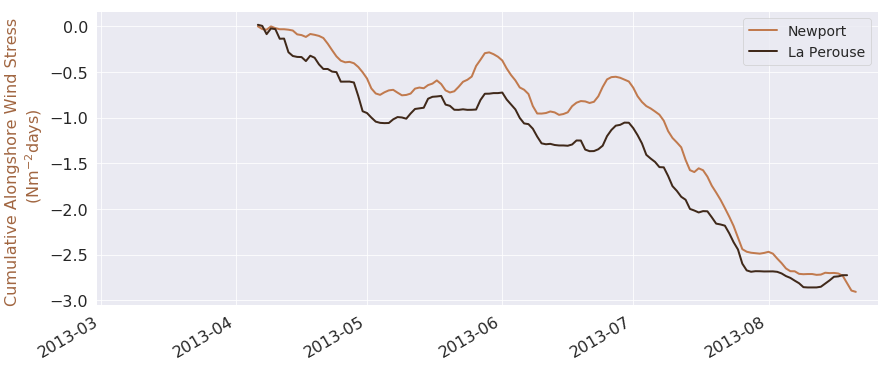

In [51]:

fig, ax2 = plt.subplots(1, 1, figsize=(14,6))

# ax2.plot(mydates_Newport , filt_v_La_Perouse, color = colors[15],  linewidth=2, label = 'La Perouse')
ax2.plot(mydates_Newport_2, wind_stress_newport_cws[96-37:96+143], c = colors[30], linewidth=2, label = 'Newport')

# ax2.plot(mydates_Newport_2, np.cumsum(wind_stress_newport[96:96+137]), c = colors[30], linewidth=2, label = 'Newport')
ax2.plot(mydates_Newport[37:-12], np.cumsum(La_perouse_stress_daily[37:-12]), c = colors[10], linewidth=2, label = 'La Perouse')

# ax2.plot(mydates_Newport , La_perouse_stress_daily, color = colors[15],  linewidth=2, label = 'La Perouse')

# ax2.plot(mydates_Newport_1, wind_stress_newport[58:243], c = colors[30], linewidth=2, label = 'Newport')


ax2.set_ylabel('Cumulative Alongshore Wind Stress \n ($\mathrm{Nm^{-2}days}$)', fontsize = 16)
# ax2.set_ylim(-0.15, 0.15)
ax2.tick_params(axis='both',labelsize =16, color = colors[25])
ax2.yaxis.label.set_color(colors[25])
ax2.legend(loc = 'upper right', fontsize  =14)
# ax2.spines['left'].set_color(colors_speed[25])
# ax2.axhline(y=0, color = 'k')
# ax2.axvline(x = mydates_Newport[mydates_Newport == '2013-08-21'], color = 'r', linestyle  = '--')
# ax2.axvline(x = time_axis[-1], color = 'r', linestyle  = '--')
ax2.set_xlim(right=mydates_Newport_2[-1], left=mydates_Newport_2[0])

fig.autofmt_xdate()

# ax2.grid()

In [32]:
# dates = pd.date_range('2010-01-01', periods=31, freq='D')
df = pd.DataFrame(mydates_Newport_2, columns=['dates'])
# use toordinal() to get datenum
df['ordinal'] = [x.toordinal() for x in df.dates]

In [33]:
df.tail(5)

,dates,ordinal
175,2013-08-22,735102
176,2013-08-23,735103
177,2013-08-24,735104
178,2013-08-25,735105
179,2013-08-26,735106


In [34]:
df.head(5)

,dates,ordinal
0,2013-02-28,734927
1,2013-03-01,734928
2,2013-03-02,734929
3,2013-03-03,734930
4,2013-03-04,734931


In [35]:
date2 = '2013-08-26'
mydates = pd.date_range(end = date2, periods=180, freq= 'D')#.strftime('%D')
mydates1 = mydates[::-1]

In [36]:
dp = pd.DataFrame(mydates1, columns=['dates'])
# use toordinal() to get datenum
dp['ordinal_reverse'] = [x.toordinal() for x in dp.dates]

In [37]:
dp.head(5)

,dates,ordinal_reverse
0,2013-08-26,735106
1,2013-08-25,735105
2,2013-08-24,735104
3,2013-08-23,735103
4,2013-08-22,735102


In [38]:
dp.tail(5)

,dates,ordinal_reverse
175,2013-03-04,734931
176,2013-03-03,734930
177,2013-03-02,734929
178,2013-03-01,734928
179,2013-02-28,734927


In [79]:
dp['ordinal_reverse'][0]-180

734926

In [96]:
dp['ordinal_reverse'][0]

735106

In [98]:
dp['ordinal_reverse'].shape

(180,)

In [100]:
dp['ordinal_reverse'][0] - 179

734927

In [93]:
dp['ordinal_reverse'][0].astype(int)

735106

In [70]:
np.mean(dep_change_time_pool)

54.29502583979329

In [39]:
grid = np.linspace(dp['ordinal_reverse'][0], dp['ordinal_reverse'][0] - 179, 10000) 

In [45]:
def calculate_kde_days_depth_change(source):

    if source == 'pool':
        

        
        kde_pool_upwell_all = scipy.stats.gaussian_kde(dp['ordinal_reverse'][0] - traj_days_final_upwell_pool,\
                                                       bw_method=0.15)
        kde_pool_timing     = scipy.stats.gaussian_kde(dp['ordinal_reverse'][0] - dep_change_time_pool) 
        grid = np.linspace(dp['ordinal_reverse'][0], dp['ordinal_reverse'][0] - 179,  10000)     
        
        kde_pool_upwell_all = kde_pool_upwell_all(grid)
        kde_pool_timing     = kde_pool_timing(grid)

        
        return kde_pool_upwell_all, kde_pool_timing,  grid
    
    if source == 'outer':
        

        
        kde_outer_upwell_all = scipy.stats.gaussian_kde(dp['ordinal_reverse'][0] - traj_days_final_upwell_outer)
        kde_outer_timing     = scipy.stats.gaussian_kde(dp['ordinal_reverse'][0] - dep_change_time_outer) 
        grid = np.linspace(dp['ordinal_reverse'][0], dp['ordinal_reverse'][0] - 199,  10000)      
        
        kde_outer_upwell_all = kde_outer_upwell_all(grid)
        kde_outer_timing     = kde_outer_timing(grid)
        
        return kde_outer_upwell_all, kde_outer_timing,  grid
        
        

In [48]:
dp['ordinal_reverse'][0]

735106

In [52]:
np.max(traj_days_final_upwell_pool)

163.33333333333334

In [57]:
def calculate_kde_days_depth_change_slight(source):

    if source == 'pool':
        

        
        kde_pool_upwell_all = scipy.stats.gaussian_kde(dp['ordinal_reverse'][0] - traj_days_final_upwell_pool[traj_days_final_upwell_pool <120])#,\
                                                       #bw_method=0.15)
        kde_pool_timing     = scipy.stats.gaussian_kde(dp['ordinal_reverse'][0] - dep_change_time_pool) 
        grid = np.linspace(dp['ordinal_reverse'][0], dp['ordinal_reverse'][0] - 179,  10000)     
        
        kde_pool_upwell_all = kde_pool_upwell_all(grid)
        kde_pool_timing     = kde_pool_timing(grid)

        
        return kde_pool_upwell_all, kde_pool_timing,  grid
    
    if source == 'outer':
        

        
        kde_outer_upwell_all = scipy.stats.gaussian_kde(dp['ordinal_reverse'][0] - traj_days_final_upwell_outer)
        kde_outer_timing     = scipy.stats.gaussian_kde(dp['ordinal_reverse'][0] - dep_change_time_outer) 
        grid = np.linspace(dp['ordinal_reverse'][0], dp['ordinal_reverse'][0] - 199,  10000)      
        
        kde_outer_upwell_all = kde_outer_upwell_all(grid)
        kde_outer_timing     = kde_outer_timing(grid)
        
        return kde_outer_upwell_all, kde_outer_timing,  grid
        
        

In [54]:
def calculate_kde_days(source):

    if source == 'pool':
        

        
        kde_pool_upwell_all = scipy.stats.gaussian_kde(dp['ordinal_reverse'][0] - traj_days_final_upwell_pool)
        kde_pool_timing     = scipy.stats.gaussian_kde(dp['ordinal_reverse'][0] - k_time_pool/24) 
        grid = np.linspace(dp['ordinal_reverse'][0], dp['ordinal_reverse'][0] - 199,  10000)   
        
        kde_pool_upwell_all = kde_pool_upwell_all(grid)
        kde_pool_timing     = kde_pool_timing(grid)

        
        return kde_pool_upwell_all, kde_pool_timing,  grid
    
    if source == 'outer':
        

        
        kde_outer_upwell_all = scipy.stats.gaussian_kde(dp['ordinal_reverse'][0] - traj_days_final_upwell_outer)
        kde_outer_timing     = scipy.stats.gaussian_kde(dp['ordinal_reverse'][0] - k_time_south/24) 
        grid = np.linspace(dp['ordinal_reverse'][0], dp['ordinal_reverse'][0] - 199,  10000)       
        
        kde_outer_upwell_all = kde_outer_upwell_all(grid)
        kde_outer_timing     = kde_outer_timing(grid)
        
        return kde_outer_upwell_all, kde_outer_timing,  grid
        
        

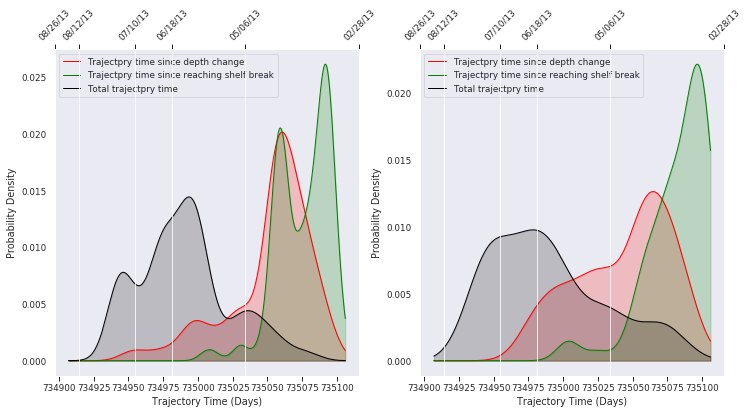

In [198]:
fig = plt.figure(figsize=(12,6))

# fig = plt.figure(figsize=(13,8))

gs2 = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(gs2[0, 0])
ax2 = plt.subplot(gs2[0, 1])

kde_pool_upwell_all, kde_pool_timing_depth,  grid = calculate_kde_days_depth_change(source='pool')


ax1.plot(grid, kde_pool_timing_depth, lw=1, color = 'r', label = "Trajectpry time since depth change")
ax1.fill_between(grid, kde_pool_timing_depth, lw=1, color  = 'r', alpha= 0.2)

ax1.plot(grid, kde_pool_timing, lw=1, color = 'g', label = "Trajectpry time since reaching shelf break")
ax1.fill_between(grid, kde_pool_timing, lw=1, color  = 'g', alpha= 0.2)

ax1.plot(grid, kde_pool_upwell_all, lw=1, color = 'k', label = "Total trajectpry time")
ax1.fill_between(grid, kde_pool_upwell_all, color = 'k',alpha = 0.2)




# ax1.set_xlim(0,180)
ax1.set_xlabel('Trajectory Time (Days)')
ax1.set_ylabel('')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax1.grid()


ax21 = ax1.twiny()
# date1 = '2013-02-27'
date2 = '2013-08-26'
mydates = pd.date_range(end = date2, periods=180, freq= 'D').strftime('%D')
mydates1 = mydates[::-1]
# new_tick_locations = np.array([0, 59, 119, 179])
new_tick_locations = np.array([0, 14, 47, 69, 112, 179])
# new_tick_locations = np.array([0, 30, 60, 90, 120, 150, 180])
# ax21.set_xlim(ax6.get_xlim())
ax21.set_xticks(new_tick_locations)
ax21.set_xticklabels(mydates1[new_tick_locations], rotation=45)
# ax21.vlines(x=mydates1[69])
# x_fmt = mpl.dates.AutoDateFormatter(mydates1[new_tick_locations])
# ax21.xaxis.set_major_formatter(x_fmt)



ax1.legend(loc = 'best')

ax1.set_ylabel('Probability Density')
# ax2_marg.legend(loc = 'best')


# ax3_marg.legend(loc = 'best')



kde_outer_upwell_all, kde_outer_timing_depth,  grid = calculate_kde_days_depth_change(source='outer')


ax2.plot(grid, kde_outer_timing_depth, lw=1, color = 'r', label = "Trajectpry time since depth change")
ax2.fill_between(grid, kde_outer_timing_depth, lw=1, color  = 'r', alpha= 0.2)

ax2.plot(grid, kde_outer_timing, lw=1, color = 'g', label = "Trajectpry time since reaching shelf break")
ax2.fill_between(grid, kde_outer_timing, lw=1, color  = 'g', alpha= 0.2)

ax2.plot(grid, kde_outer_upwell_all, lw=1, color = 'k', label = "Total trajectpry time")
ax2.fill_between(grid, kde_outer_upwell_all, color = 'k',alpha = 0.2)




# ax2.set_xlim(0,180)
ax2.set_xlabel('Trajectory Time (Days)')
ax2.set_ylabel('')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax2.grid()


ax22 = ax2.twiny()
# date1 = '2013-02-27'
date2 = '2013-08-26'
mydates = pd.date_range(end = date2, periods=180, freq= 'D').strftime('%D')
mydates1 = mydates[::-1]
# new_tick_locations = np.array([0, 59, 119, 179])
new_tick_locations = np.array([0, 14, 47, 69, 112, 179])
# new_tick_locations = np.array([0, 30, 60, 90, 120, 150, 180])
# ax21.set_xlim(ax6.get_xlim())
ax22.set_xticks(new_tick_locations)
ax22.set_xticklabels(mydates1[new_tick_locations], rotation=45)

ax2.legend(loc = 'best')

ax2.set_ylabel('Probability Density')

In [114]:
La_perouse_stress_daily[37:-12].shape

(136,)

In [168]:
df['ordinal'][0]+179

735106

In [120]:
mydates_Newport[37:-12]

DatetimeIndex(['2013-04-06', '2013-04-07', '2013-04-08', '2013-04-09',
               '2013-04-10', '2013-04-11', '2013-04-12', '2013-04-13',
               '2013-04-14', '2013-04-15',
               ...
               '2013-08-10', '2013-08-11', '2013-08-12', '2013-08-13',
               '2013-08-14', '2013-08-15', '2013-08-16', '2013-08-17',
               '2013-08-18', '2013-08-19'],
              dtype='datetime64[ns]', length=136, freq='D')

In [121]:
mydates_Newport_2

DatetimeIndex(['2013-02-28', '2013-03-01', '2013-03-02', '2013-03-03',
               '2013-03-04', '2013-03-05', '2013-03-06', '2013-03-07',
               '2013-03-08', '2013-03-09',
               ...
               '2013-08-17', '2013-08-18', '2013-08-19', '2013-08-20',
               '2013-08-21', '2013-08-22', '2013-08-23', '2013-08-24',
               '2013-08-25', '2013-08-26'],
              dtype='datetime64[ns]', length=180, freq='D')

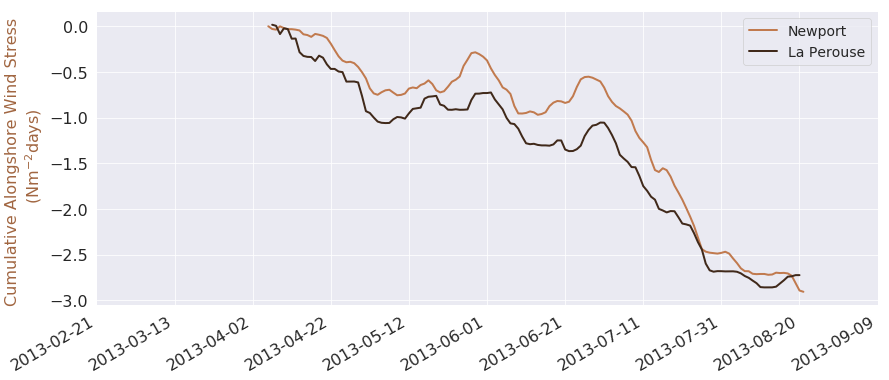

In [209]:

fig, ax2 = plt.subplots(1, 1, figsize=(14,6))

# ax2.plot(mydates_Newport , filt_v_La_Perouse, color = colors[15],  linewidth=2, label = 'La Perouse')
ax2.plot(df['ordinal'], wind_stress_newport_cws[96-37:96+143], c = colors[30], linewidth=2, label = 'Newport')

# ax2.plot(mydates_Newport_2, np.cumsum(wind_stress_newport[96:96+137]), c = colors[30], linewidth=2, label = 'Newport')
ax2.plot(df['ordinal'][38:-6], np.cumsum(La_perouse_stress_daily[37:-12]), c = colors[10], linewidth=2, label = 'La Perouse')

# ax2.plot(mydates_Newport , La_perouse_stress_daily, color = colors[15],  linewidth=2, label = 'La Perouse')

# ax2.plot(mydates_Newport_1, wind_stress_newport[58:243], c = colors[30], linewidth=2, label = 'Newport')


ax2.set_ylabel('Cumulative Alongshore Wind Stress \n ($\mathrm{Nm^{-2}days}$)', fontsize = 16)
# ax2.set_ylim(-0.15, 0.15)
ax2.tick_params(axis='both',labelsize =16, color = colors[25])
ax2.yaxis.label.set_color(colors[25])
ax2.legend(loc = 'upper right', fontsize  =14)

ax2.set_xlim(right=df['ordinal'][0]+179, left=df['ordinal'][0])


# ax2.set_xticklabels([])

# x_ticks = ax2.get_xticks()
# ax2.set_xticks(x_ticks[:]
# xlabels = [df['dates']]
# ax2.set_xticklabels(xlabels)

# new_tick_locations = np.array([0, 14, 47, 69, 112, 179])
# new_tick_locations = np.array([0, 30, 60, 90, 120, 150, 180])
# new_tick_locations = ax2.set_xlim(ax2.get_xlim())
# ax2.set_xticks(new_tick_locations)
# ax2.set_xticklabels(mydates_Newport_2[new_tick_locations], rotation=45)


x_ticks = ax2.get_xticks()
ax2.set_xticks(x_ticks[::1])
xlabels = [datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::1]]
ax2.set_xticklabels(xlabels)


fig.autofmt_xdate()

# ax2.grid()

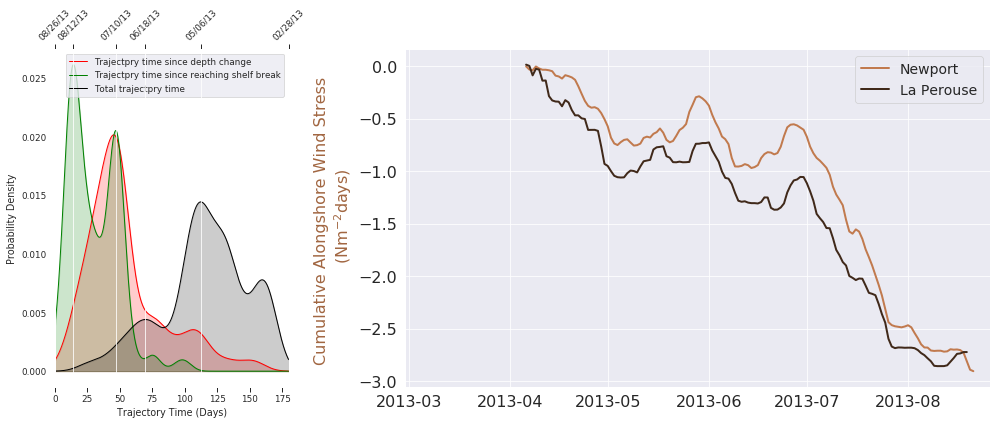

In [256]:
fig = plt.figure(figsize=(14,6))


gs2 = gridspec.GridSpec(ncols=3, nrows=1)


ax2 = plt.subplot(gs2[0, 1:])
ax1 = plt.subplot(gs2[0, 0], frameon = False)




kde_pool_upwell_all, kde_pool_timing_depth,  grid = calculate_kde_days_depth_change(source='pool')


ax1.plot(grid, kde_pool_timing_depth, lw=1, color = 'r', label = "Trajectpry time since depth change")
ax1.fill_between(grid, kde_pool_timing_depth, lw=1, color  = 'r', alpha= 0.2)

ax1.plot(grid, kde_pool_timing, lw=1, color = 'g', label = "Trajectpry time since reaching shelf break")
ax1.fill_between(grid, kde_pool_timing, lw=1, color  = 'g', alpha= 0.2)

ax1.plot(grid, kde_pool_upwell_all, lw=1, color = 'k', label = "Total trajectpry time")
ax1.fill_between(grid, kde_pool_upwell_all, color = 'k',alpha = 0.2)




ax1.set_xlim(0,180)
ax1.set_xlabel('Trajectory Time (Days)')
ax1.set_ylabel('')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax1.grid()


ax21 = ax1.twiny()
# date1 = '2013-02-27'
date2 = '2013-08-26'
mydates = pd.date_range(end = date2, periods=180, freq= 'D').strftime('%D')
mydates1 = mydates[::-1]
# new_tick_locations = np.array([0, 59, 119, 179])
new_tick_locations = np.array([0, 14, 47, 69, 112, 179])
# new_tick_locations = np.array([0, 30, 60, 90, 120, 150, 180])
# ax21.set_xlim(ax6.get_xlim())
ax21.set_xticks(new_tick_locations)
ax21.set_xticklabels(mydates1[new_tick_locations], rotation=45)
# ax21.vlines(x=mydates1[69])
# x_fmt = mpl.dates.AutoDateFormatter(mydates1[new_tick_locations])
# ax21.xaxis.set_major_formatter(x_fmt)



ax1.legend(loc = 'best')

ax1.set_ylabel('Probability Density')

## ax2.plot(mydates_Newport , filt_v_La_Perouse, color = colors[15],  linewidth=2, label = 'La Perouse')
ax2.plot(mydates_Newport_2, wind_stress_newport_cws[96-37:96+143], c = colors[30], linewidth=2, label = 'Newport')

# ax2.plot(mydates_Newport_2, np.cumsum(wind_stress_newport[96:96+137]), c = colors[30], linewidth=2, label = 'Newport')
ax2.plot(mydates_Newport[37:-12], np.cumsum(La_perouse_stress_daily[37:-12]), c = colors[10], linewidth=2, label = 'La Perouse')

# ax2.plot(mydates_Newport , La_perouse_stress_daily, color = colors[15],  linewidth=2, label = 'La Perouse')

# ax2.plot(mydates_Newport_1, wind_stress_newport[58:243], c = colors[30], linewidth=2, label = 'Newport')


ax2.set_ylabel('Cumulative Alongshore Wind Stress \n ($\mathrm{Nm^{-2}days}$)', fontsize = 16)
# ax2.set_ylim(-0.15, 0.15)
ax2.tick_params(axis='both',labelsize =16, color = colors[25])
ax2.yaxis.label.set_color(colors[25])
ax2.legend(loc = 'upper right', fontsize  =14)
# ax2.spines['left'].set_color(colors_speed[25])
# ax2.axhline(y=0, color = 'k')
# ax2.axvline(x = mydates_Newport[mydates_Newport == '2013-08-21'], color = 'r', linestyle  = '--')
# ax2.axvline(x = time_axis[-1], color = 'r', linestyle  = '--')
ax2.set_xlim(right=mydates_Newport_2[-1], left=mydates_Newport_2[0])

# fig.autofmt_xdate()

fig.tight_layout()

# ax2.grid()


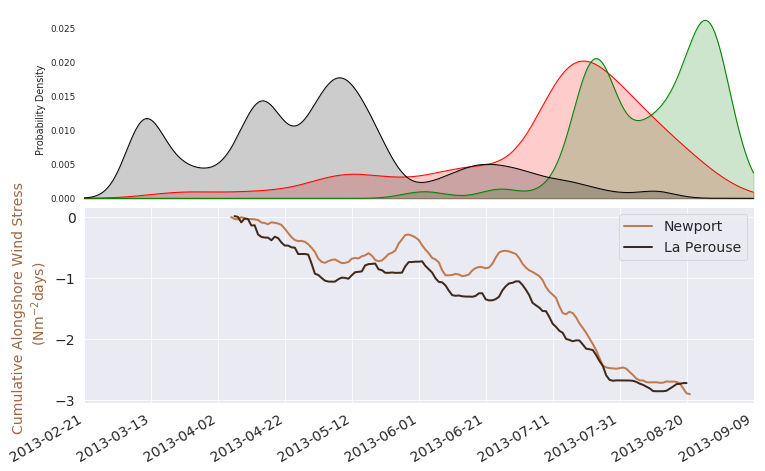

In [221]:
fig = plt.figure(figsize=(12,8))


gs2 = gridspec.GridSpec(ncols=1, nrows=2)


ax2 = plt.subplot(gs2[1, 0])
ax1 = plt.subplot(gs2[0, 0], sharex=ax2, frameon = False)




kde_pool_upwell_all, kde_pool_timing_depth,  grid = calculate_kde_days_depth_change(source='pool')


ax1.plot(grid, kde_pool_timing_depth, lw=1, color = 'r', label = "Trajectpry time since depth change")
ax1.fill_between(grid, kde_pool_timing_depth, lw=1, color  = 'r', alpha= 0.2)

ax1.plot(grid, kde_pool_timing, lw=1, color = 'g', label = "Trajectpry time since reaching shelf break")
ax1.fill_between(grid, kde_pool_timing, lw=1, color  = 'g', alpha= 0.2)

ax1.plot(grid, kde_pool_upwell_all, lw=1, color = 'k', label = "Total trajectpry time")
ax1.fill_between(grid, kde_pool_upwell_all, color = 'k',alpha = 0.2)




ax1.set_xlim(right=df['ordinal'][0]+179, left=df['ordinal'][0])
# ax1.set_xlabel('Trajectory Time (Days)')
ax1.set_ylabel('Probability Density')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax1.grid()


# ax2.plot(mydates_Newport , filt_v_La_Perouse, color = colors[15],  linewidth=2, label = 'La Perouse')
ax2.plot(df['ordinal'], wind_stress_newport_cws[96-37:96+143], c = colors[30], linewidth=2, label = 'Newport')

# ax2.plot(mydates_Newport_2, np.cumsum(wind_stress_newport[96:96+137]), c = colors[30], linewidth=2, label = 'Newport')
ax2.plot(df['ordinal'][38:-6], np.cumsum(La_perouse_stress_daily[37:-12]), c = colors[10], linewidth=2, label = 'La Perouse')

# ax2.plot(mydates_Newport , La_perouse_stress_daily, color = colors[15],  linewidth=2, label = 'La Perouse')

# ax2.plot(mydates_Newport_1, wind_stress_newport[58:243], c = colors[30], linewidth=2, label = 'Newport')


ax2.set_ylabel('Cumulative Alongshore Wind Stress \n ($\mathrm{Nm^{-2}days}$)', fontsize = 14)
# ax2.set_ylim(-0.15, 0.15)
ax2.tick_params(axis='both',labelsize =14, color = colors[25])
ax2.yaxis.label.set_color(colors[25])
ax2.legend(loc = 'upper right', fontsize  =14)

ax2.set_xlim(right=df['ordinal'][0]+179, left=df['ordinal'][0])


# ax2.set_xticklabels([])

# x_ticks = ax2.get_xticks()
# ax2.set_xticks(x_ticks[:]
# xlabels = [df['dates']]
# ax2.set_xticklabels(xlabels)

# new_tick_locations = np.array([0, 14, 47, 69, 112, 179])
# new_tick_locations = np.array([0, 30, 60, 90, 120, 150, 180])
# new_tick_locations = ax2.set_xlim(ax2.get_xlim())
# ax2.set_xticks(new_tick_locations)
# ax2.set_xticklabels(mydates_Newport_2[new_tick_locations], rotation=45)


x_ticks = ax2.get_xticks()
ax2.set_xticks(x_ticks[::1])
xlabels = [datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::1]]
ax2.set_xticklabels(xlabels)


gs2.update(wspace=0, hspace=0)

fig.autofmt_xdate()

# fig.tight_layout()

# ax2.grid()


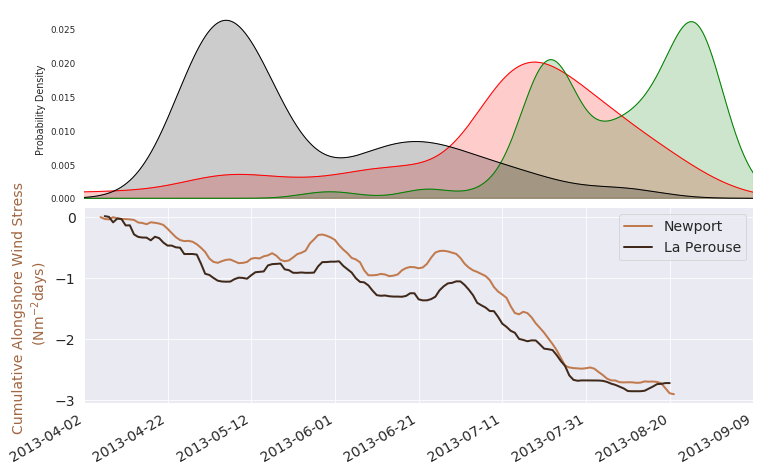

In [58]:
fig = plt.figure(figsize=(12,8))


gs2 = gridspec.GridSpec(ncols=1, nrows=2)


ax2 = plt.subplot(gs2[1, 0])
ax1 = plt.subplot(gs2[0, 0], sharex=ax2, frameon = False)




kde_pool_upwell_all, kde_pool_timing_depth,  grid = calculate_kde_days_depth_change_slight(source='pool')


ax1.plot(grid, kde_pool_timing_depth, lw=1, color = 'r', label = "Trajectpry time since depth change")
ax1.fill_between(grid, kde_pool_timing_depth, lw=1, color  = 'r', alpha= 0.2)

ax1.plot(grid, kde_pool_timing, lw=1, color = 'g', label = "Trajectpry time since reaching shelf break")
ax1.fill_between(grid, kde_pool_timing, lw=1, color  = 'g', alpha= 0.2)

ax1.plot(grid, kde_pool_upwell_all, lw=1, color = 'k', label = "Total trajectpry time")
ax1.fill_between(grid, kde_pool_upwell_all, color = 'k',alpha = 0.2)




ax1.set_xlim(right=df['ordinal'][0]+179, left=df['ordinal'][0])
# ax1.set_xlabel('Trajectory Time (Days)')
ax1.set_ylabel('Probability Density')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax1.grid()


# ax2.plot(mydates_Newport , filt_v_La_Perouse, color = colors[15],  linewidth=2, label = 'La Perouse')
ax2.plot(df['ordinal'], wind_stress_newport_cws[96-37:96+143], c = colors[30], linewidth=2, label = 'Newport')

# ax2.plot(mydates_Newport_2, np.cumsum(wind_stress_newport[96:96+137]), c = colors[30], linewidth=2, label = 'Newport')
ax2.plot(df['ordinal'][38:-6], np.cumsum(La_perouse_stress_daily[37:-12]), c = colors[10], linewidth=2, label = 'La Perouse')

# ax2.plot(mydates_Newport , La_perouse_stress_daily, color = colors[15],  linewidth=2, label = 'La Perouse')

# ax2.plot(mydates_Newport_1, wind_stress_newport[58:243], c = colors[30], linewidth=2, label = 'Newport')


ax2.set_ylabel('Cumulative Alongshore Wind Stress \n ($\mathrm{Nm^{-2}days}$)', fontsize = 14)
# ax2.set_ylim(-0.15, 0.15)
ax2.tick_params(axis='both',labelsize =14, color = colors[25])
ax2.yaxis.label.set_color(colors[25])
ax2.legend(loc = 'upper right', fontsize  =14)

ax2.set_xlim(right=df['ordinal'][0]+179, left=df['ordinal'][0]+40)


# ax2.set_xticklabels([])

# x_ticks = ax2.get_xticks()
# ax2.set_xticks(x_ticks[:]
# xlabels = [df['dates']]
# ax2.set_xticklabels(xlabels)

# new_tick_locations = np.array([0, 14, 47, 69, 112, 179])
# new_tick_locations = np.array([0, 30, 60, 90, 120, 150, 180])
# new_tick_locations = ax2.set_xlim(ax2.get_xlim())
# ax2.set_xticks(new_tick_locations)
# ax2.set_xticklabels(mydates_Newport_2[new_tick_locations], rotation=45)


x_ticks = ax2.get_xticks()
ax2.set_xticks(x_ticks[::1])
xlabels = [datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::1]]
ax2.set_xticklabels(xlabels)


gs2.update(wspace=0, hspace=0)

fig.autofmt_xdate()

# fig.tight_layout()

# ax2.grid()


In [87]:
date1_Newport_1 = '2013-02-28'
# date2_Newport_1 = '2013-08-31'
mydates_Newport_2 = pd.date_range(start=date1_Newport_1, periods=143+37+15, freq= 'D')

In [88]:
mydates_Newport_2[-1]

Timestamp('2013-09-10 00:00:00', freq='D')

In [89]:
# dates = pd.date_range('2010-01-01', periods=31, freq='D')
dz = pd.DataFrame(mydates_Newport_2, columns=['dates'])
# use toordinal() to get datenum
dz['ordinal'] = [x.toordinal() for x in dz.dates]

In [117]:
La_Peruse_data = pd.read_table('/data/ssahu/Falkor_2013/winds/La_persue_wave_buoy.csv',delim_whitespace=1,header = None, skiprows=7)

a = La_Peruse_data[0].str.split(',', expand=True)

b = La_Peruse_data[1].str.split(',', expand=True)

df_La_Peruse = pd.concat([a, b], axis=1)

df_cut = df_La_Peruse.drop(df_La_Peruse.columns[14:], axis=1)

columns = ['STN_ID','DATE','TIME','Qflag','LATITUDE','LONGITUDE','DEPTH','VCAR','VTPK','VWH','VCMX','VTP','WDIR','WSPD','WSS','GSPD','WDIR','WSPD','WSS','GSPD','ATMS','ATMS','DRYT','SSTP']

effective = columns[:14]

df_cut.columns = effective
df_cut = df_cut.drop('Qflag',axis =1)

df_cut['Date_time']= df_cut['DATE'] + " " + df_cut['TIME']

LA_PERUSE_array = df_cut.as_matrix()

start_index_2013_Feb  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '04/07/2013')))[0,0]

end_index_2013_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '09/10/2013')))[-1,0]

wind_spd = LA_PERUSE_array[start_index_2013_Feb:end_index_2013_September,-2].astype(np.float)

wind_dir = LA_PERUSE_array[start_index_2013_Feb:end_index_2013_September,-3].astype(np.float)

u_wind = np.multiply(wind_spd[:],np.cos(wind_dir))

v_wind = np.multiply(wind_spd[:],np.sin(wind_dir))

time_2013 = LA_PERUSE_array[start_index_2013_Feb:end_index_2013_September,-1].astype(str)

datetime_2013 = np.empty_like(time_2013)

for i in np.arange(datetime_2013.shape[0]):
    datetime_2013[i] = datetime.strptime(time_2013[i], '%m/%d/%Y %H:%M')
    
datetime_2013 = datetime_2013.astype(np.datetime64)


ws_La_Perouse = wind_spd
wd_La_Perouse = wind_dir

theta = find_principal_axis_of_dataset_in_degrees(u_data=u_wind, v_data=v_wind)


wind_spd = LA_PERUSE_array[start_index_2013_Feb:end_index_2013_September,-2].astype(np.float)

wind_dir = LA_PERUSE_array[start_index_2013_Feb:end_index_2013_September,-3].astype(np.float)

v_wind_rot = np.empty_like(wind_dir)

v_wind_rot[:] = -1*np.multiply(wind_spd[:],np.cos(np.deg2rad(wind_dir[:] - theta)))

# v_wind_rot = np.multiply(wind_spd[:],np.sin(np.deg2rad(wind_dir[:] - 57)))

time_2013 = LA_PERUSE_array[start_index_2013_Feb:end_index_2013_September,-1].astype(str)

datetime_2013 = np.empty_like(time_2013)

for i in np.arange(datetime_2013.shape[0]):
    datetime_2013[i] = datetime.strptime(time_2013[i], '%m/%d/%Y %H:%M')
    
datetime_2013 = datetime_2013.astype(np.datetime64)

range = pd.date_range('2013-02-28', '2013-09-10', freq='D')



La_perouse_series = pd.Series(v_wind_rot, index=datetime_2013)
daily_north_La_Perouse = La_perouse_series.resample('D').mean()

La_perouse_stress_daily_extend = np.sign(daily_north_La_Perouse)*stress(sp=daily_north_La_Perouse)

In [118]:
La_perouse_stress_daily.shape

(185,)

In [119]:
La_perouse_stress_daily_extend.shape

(157,)

In [94]:
dz['ordinal'][38]

734965

In [109]:
dz.iloc[-1]

dates      2013-09-10 00:00:00
ordinal                 735121
Name: 194, dtype: object

In [127]:
dz.iloc[-22]

dates      2013-08-20 00:00:00
ordinal                 735100
Name: 173, dtype: object

In [113]:
La_perouse_stress_daily_extend[:].shape

(158,)

In [129]:
along_model.shape

(185, 32)

In [134]:
zlevels[25]

186.12556

In [147]:
np.nanmin(along_model)

-0.58531898163371388

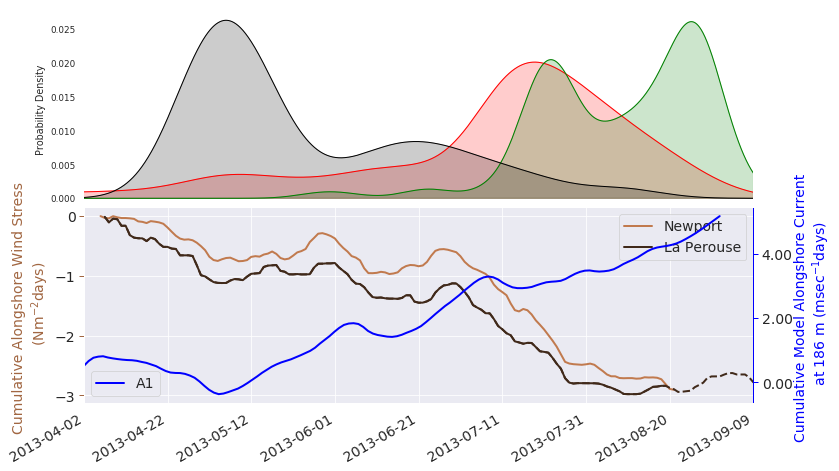

In [157]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(12,8))


gs2 = gridspec.GridSpec(ncols=1, nrows=2)


ax2 = plt.subplot(gs2[1, 0])
ax1 = plt.subplot(gs2[0, 0], sharex=ax2, frameon = False)




kde_pool_upwell_all, kde_pool_timing_depth,  grid = calculate_kde_days_depth_change_slight(source='pool')


ax1.plot(grid, kde_pool_timing_depth, lw=1, color = 'r', label = "Trajectpry time since depth change")
ax1.fill_between(grid, kde_pool_timing_depth, lw=1, color  = 'r', alpha= 0.2)

ax1.plot(grid, kde_pool_timing, lw=1, color = 'g', label = "Trajectpry time since reaching shelf break")
ax1.fill_between(grid, kde_pool_timing, lw=1, color  = 'g', alpha= 0.2)

ax1.plot(grid, kde_pool_upwell_all, lw=1, color = 'k', label = "Total trajectpry time")
ax1.fill_between(grid, kde_pool_upwell_all, color = 'k',alpha = 0.2)




ax1.set_xlim(right=df['ordinal'][0]+179, left=df['ordinal'][0])
# ax1.set_xlabel('Trajectory Time (Days)')
ax1.set_ylabel('Probability Density')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax1.grid()

ax3 = ax2.twinx()
ax3.plot(dz['ordinal'][38:-22], np.cumsum(along_model[38:-12,25]), c = 'b', linewidth=2, label = 'A1')

ax3.grid()

ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.set_ylabel('Cumulative Model Alongshore Current \n at 186 m ($\mathrm{m sec^{-1}days}$)', fontsize = 14)
# ax2.set_ylim(-0.15, 0.15)
ax3.tick_params(axis='both',labelsize =14, color = 'b')
ax3.yaxis.label.set_color('b')
ax3.legend(loc = 'lower left', fontsize  =14)
ax3.spines['right'].set_color('b')




# ax2.plot(mydates_Newport , filt_v_La_Perouse, color = colors[15],  linewidth=2, label = 'La Perouse')
ax2.plot(df['ordinal'], wind_stress_newport_cws[96-37:96+143], c = colors[30], linewidth=2, label = 'Newport')

# ax2.plot(mydates_Newport_2, np.cumsum(wind_stress_newport[96:96+137]), c = colors[30], linewidth=2, label = 'Newport')
ax2.plot(dz['ordinal'][38:-22], np.cumsum(La_perouse_stress_daily_extend[:-22]), c = colors[10], linewidth=2, label = 'La Perouse')

ax2.plot(dz['ordinal'][38:], np.cumsum(La_perouse_stress_daily_extend[:]), c = colors[10], linewidth=2, linestyle='dashed')
# ax2.plot(mydates_Newport , La_perouse_stress_daily, color = colors[15],  linewidth=2, label = 'La Perouse')

# ax2.plot(mydates_Newport_1, wind_stress_newport[58:243], c = colors[30], linewidth=2, label = 'Newport')


ax2.set_ylabel('Cumulative Alongshore Wind Stress \n ($\mathrm{Nm^{-2}days}$)', fontsize = 14)
# ax2.set_ylim(-0.15, 0.15)
ax2.tick_params(axis='both',labelsize =14, color = colors[25])
ax2.yaxis.label.set_color(colors[25])
ax2.legend(loc = 'upper right', fontsize  =14)

ax2.set_xlim(right=df['ordinal'][0]+179, left=df['ordinal'][0]+40)
ax2.spines['left'].set_color(colors[25])

# ax2.set_xticklabels([])

# x_ticks = ax2.get_xticks()
# ax2.set_xticks(x_ticks[:]
# xlabels = [df['dates']]
# ax2.set_xticklabels(xlabels)

# new_tick_locations = np.array([0, 14, 47, 69, 112, 179])
# new_tick_locations = np.array([0, 30, 60, 90, 120, 150, 180])
# new_tick_locations = ax2.set_xlim(ax2.get_xlim())
# ax2.set_xticks(new_tick_locations)
# ax2.set_xticklabels(mydates_Newport_2[new_tick_locations], rotation=45)


x_ticks = ax2.get_xticks()
ax2.set_xticks(x_ticks[::1])
xlabels = [datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::1]]
ax2.set_xticklabels(xlabels)


gs2.update(wspace=0, hspace=0)

fig.autofmt_xdate()

# fig.tight_layout()

# ax2.grid()


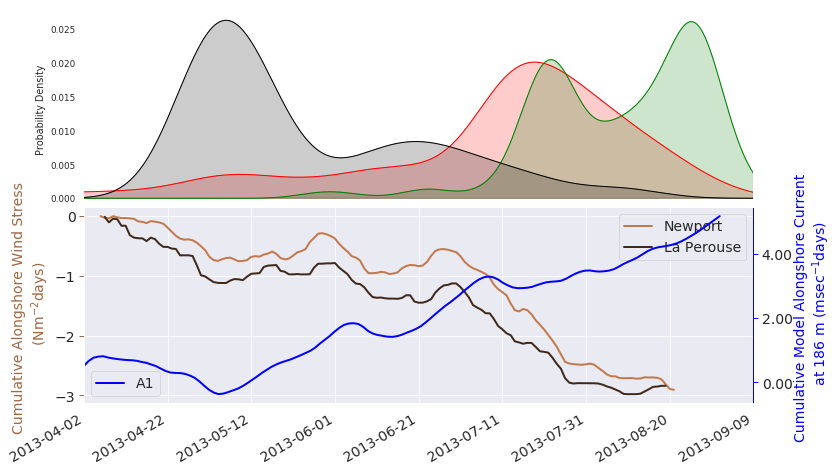

In [158]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(12,8))


gs2 = gridspec.GridSpec(ncols=1, nrows=2)


ax2 = plt.subplot(gs2[1, 0])
ax1 = plt.subplot(gs2[0, 0], sharex=ax2, frameon = False)




kde_pool_upwell_all, kde_pool_timing_depth,  grid = calculate_kde_days_depth_change_slight(source='pool')


ax1.plot(grid, kde_pool_timing_depth, lw=1, color = 'r', label = "Trajectpry time since depth change")
ax1.fill_between(grid, kde_pool_timing_depth, lw=1, color  = 'r', alpha= 0.2)

ax1.plot(grid, kde_pool_timing, lw=1, color = 'g', label = "Trajectpry time since reaching shelf break")
ax1.fill_between(grid, kde_pool_timing, lw=1, color  = 'g', alpha= 0.2)

ax1.plot(grid, kde_pool_upwell_all, lw=1, color = 'k', label = "Total trajectpry time")
ax1.fill_between(grid, kde_pool_upwell_all, color = 'k',alpha = 0.2)




ax1.set_xlim(right=df['ordinal'][0]+179, left=df['ordinal'][0])
# ax1.set_xlabel('Trajectory Time (Days)')
ax1.set_ylabel('Probability Density')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax1.grid()

ax3 = ax2.twinx()
ax3.plot(dz['ordinal'][38:-22], np.cumsum(along_model[38:-12,25]), c = 'b', linewidth=2, label = 'A1')

ax3.grid()

ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.set_ylabel('Cumulative Model Alongshore Current \n at 186 m ($\mathrm{m sec^{-1}days}$)', fontsize = 14)
# ax2.set_ylim(-0.15, 0.15)
ax3.tick_params(axis='both',labelsize =14, color = 'b')
ax3.yaxis.label.set_color('b')
ax3.legend(loc = 'lower left', fontsize  =14)
ax3.spines['right'].set_color('b')




# ax2.plot(mydates_Newport , filt_v_La_Perouse, color = colors[15],  linewidth=2, label = 'La Perouse')
ax2.plot(df['ordinal'], wind_stress_newport_cws[96-37:96+143], c = colors[30], linewidth=2, label = 'Newport')

# ax2.plot(mydates_Newport_2, np.cumsum(wind_stress_newport[96:96+137]), c = colors[30], linewidth=2, label = 'Newport')
ax2.plot(dz['ordinal'][38:-22], np.cumsum(La_perouse_stress_daily_extend[:-22]), c = colors[10], linewidth=2, label = 'La Perouse')

# ax2.plot(dz['ordinal'][38:], np.cumsum(La_perouse_stress_daily_extend[:]), c = colors[10], linewidth=2, linestyle='dashed')
# ax2.plot(mydates_Newport , La_perouse_stress_daily, color = colors[15],  linewidth=2, label = 'La Perouse')

# ax2.plot(mydates_Newport_1, wind_stress_newport[58:243], c = colors[30], linewidth=2, label = 'Newport')


ax2.set_ylabel('Cumulative Alongshore Wind Stress \n ($\mathrm{Nm^{-2}days}$)', fontsize = 14)
# ax2.set_ylim(-0.15, 0.15)
ax2.tick_params(axis='both',labelsize =14, color = colors[25])
ax2.yaxis.label.set_color(colors[25])
ax2.legend(loc = 'upper right', fontsize  =14)

ax2.set_xlim(right=df['ordinal'][0]+179, left=df['ordinal'][0]+40)
ax2.spines['left'].set_color(colors[25])

# ax2.set_xticklabels([])

# x_ticks = ax2.get_xticks()
# ax2.set_xticks(x_ticks[:]
# xlabels = [df['dates']]
# ax2.set_xticklabels(xlabels)

# new_tick_locations = np.array([0, 14, 47, 69, 112, 179])
# new_tick_locations = np.array([0, 30, 60, 90, 120, 150, 180])
# new_tick_locations = ax2.set_xlim(ax2.get_xlim())
# ax2.set_xticks(new_tick_locations)
# ax2.set_xticklabels(mydates_Newport_2[new_tick_locations], rotation=45)


x_ticks = ax2.get_xticks()
ax2.set_xticks(x_ticks[::1])
xlabels = [datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::1]]
ax2.set_xticklabels(xlabels)


gs2.update(wspace=0, hspace=0)

fig.autofmt_xdate()

# fig.tight_layout()

# ax2.grid()


In [21]:
x_200_total = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
x_200_total_eddy_water_acc_iso_two_more_months.npy')

y_200_total  = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
y_200_total_eddy_water_acc_iso_iso_two_more_months.npy')

x_200_total = x_200_total[~np.isnan(y_200_total)]
y_200_total = y_200_total[~np.isnan(y_200_total)]

In [22]:
x_200_total.shape

(645,)

In [31]:
y_200_total.shape

(645,)

In [24]:
k_time_pool = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/time_of_crossing_iso_pool_water_two_more_months.npy')

In [43]:
timing_of_shelf_pool = pd.Series(k_time_pool/24)

(0, 70)

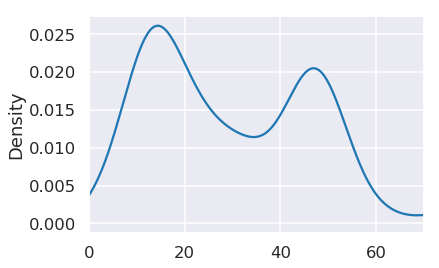

In [44]:
ax = timing_of_shelf_pool.plot.kde()

ax.set_xlim(0,70)

In [ ]:
start_pool = pd.Series()

In [27]:
k_time_south = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
time_of_crossing_iso_south_outer_water_two_more_months.npy')

In [28]:
timing_of_shelf_south = pd.Series(k_time_south/24)

(-20, 100)

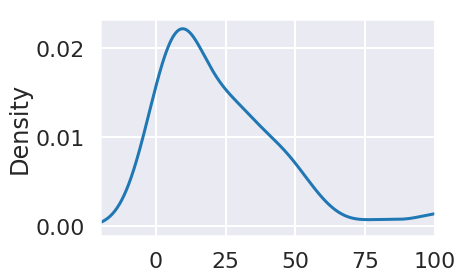

In [29]:
ax = timing_of_shelf_south.plot.kde()

ax.set_xlim(-20,100)

NameError: name 'k_time' is not defined

In [31]:
np.min(k_time)

1.0

In [32]:
np.max(k_time)

2466.0

In [39]:
k_cross = np.empty_like((cross_index))

In [40]:
k_cross.shape

(645,)

In [ ]:
k_cross = np.empty_like(cross_index_low)

for m in np.arange(cross_index_low.shape[0]):

    for k in np.arange(1,traj_lon.shape[0]-1):


        y, x = geo_tools.find_closest_model_point(traj_lon[k,cross_index_low[m].astype(int)],\
                                              traj_lat[k,cross_index_low[m].astype(int)],\
                                  lon,lat,grid='NEMO',tols=\
                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

        if (y,x) == (y_200_total[m],x_200_total[m]):

            k_cross[m] = k

            break
            
    print(m)
        
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258


In [ ]:
k_cross[189]

In [32]:
y

nan

In [34]:
np.max(cross_index)

1142.0

In [36]:
traj_lon.shape[0]

3921

In [35]:
traj_lon.shape

(3921, 1143)